# Projet 5 : Catégorisez automatiquement des questions
Étudiant BOUTROIX Laurent parcours Ingénieur Machine Learning

## Un Énoncé :
Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Des Contraintes :
Mettre en œuvre une approche non supervisée.
Utiliser une approche supervisée ou non pour extraire des tags à partir des résultats précédents.
Comparer ses résultats à une approche purement supervisée, après avoir appliqué des méthodes d’extraction de features spécifiques des données textuelles.
Mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation.
Pour suivre les modifications du code final à déployer, utiliser un logiciel de gestion de versions, par exemple Git.

## Une Problématique :
Mettre en place un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

## Hypothèse Générale :
Pouvons-nous mettre en place un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question ?

## Hypothèses Secondaires :
Pouvons-nous mettre en place une méthode d’évaluation propre, avec une séparation du jeu de données pour l’évaluation ?

Pouvons-nous déployer le code final pour le mettre à la dispostion de la communauté ?


## Partie 2 : Tests des différents modèles.

### Installation des dépendances :

In [16]:
# pip install pyldavis

### Importation des dépendances :

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import ceil,sqrt,floor
from pprint import pprint

import dataframe_image as dfi

import random

import joblib

from ast import literal_eval

from PIL import Image
import dataframe_image as dfi

import datetime as dt
from datetime import date,timedelta
import time

#Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

#LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

#Dimension reduction
from sklearn.decomposition import PCA
from sklearn import decomposition
import matplotlib.cm as cm

#pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


#Supervisée
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain

#models
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

#metrics
#from sklearn.metrics import metrics
import sklearn.metrics as metrics

#GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [18]:
random.seed(5)

In [19]:
start_dr1 = time.process_time()

### Importation de la base de données résultantes de la première partie :

In [20]:
df = pd.read_csv("./dfP05modelisation.csv", converters={"tag_pop_tok": literal_eval, "question_lemtokcl": literal_eval})
df = df.drop(df.columns[[0]], axis=1)

### Définition des fonctions :

##### Définition d'une fonction `display_scree_plot()` qui trace l'éboulis des valeurs propres d'une réduction de dimension PCA.

In [21]:
def display_scree_plot(PcA):
    scree = PcA.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.axhline(y=95,color='green',linestyle='--', label = 'Inertie = 95%')
    plt.axhline(y=80,color='green',linestyle='--', label = 'Inertie = 80%')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.legend()
    plt.show(block=False)

In [22]:
def display_scree_plot_2(PcA, x_value):
    scree = PcA.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.axhline(y=95,color='green',linestyle='--', label = 'Inertie = 95%')
    plt.axhline(y=80,color='green',linestyle='--', label = 'Inertie = 80%')
    plt.axvline(x=950,color='blue',linestyle='-', label = 'x = 950')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.legend()
    plt.show(block=False)

##### Définition d'une fonction `print_topics()` qui affiche les topics déterminés par le modèle choisi.

In [23]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

##### Définition d'une fonction `metrics_model()` qui affiche dans un tableau différentes métriques d'un modèle de prédiction.

In [24]:
def metric_model(model_name, y_test, y_pred, time):   
    
    accuracy = metrics.accuracy_score(y_test, y_pred)
    score = metrics.f1_score(y_pred, y_test, average='weighted')
    macro_score = metrics.f1_score(y_test, y_pred, average='macro'),
    micro_score = metrics.f1_score(y_test, y_pred, average='micro'),
    jaccard = metrics.jaccard_score(y_test, y_pred, average='weighted')
    recall = metrics.recall_score(y_test, y_pred, average='weighted')
    precision = metrics.precision_score(y_test, y_pred, average='weighted')

    tab = pd.DataFrame({"Accuracy": [accuracy],"F1": [score], "Macro_f1_score": [macro_score], "Micro_f1_score": [micro_score], "Jaccard": [jaccard],"Recall": [recall],"Precision": [precision],"Run Time": [time]}, index=[model_name])
    tab.style.set_properties()
         
    return(tab)

### Inspection de df :

In [25]:
df

,Id,CreationDate,Tags,tag,tag_pop_norm,tag_pop_tok,question,question_lemtokcl,nb_w_title,nb_w_body,nb_w_quest,nb_tag,ViewCount,AnswerCount,Score
0,9,2008-07-31 23:40:59,<c#><.net><datetime>,csharp dotnet datetime,csharp dotnet datetime,"[csharp, dotnet, datetime]",how do i calculate someone's age based on a da...,"[calculate, age, base, datetime, type, birthda...",12,15,27,3,716062,69,2081
1,59,2008-08-01 13:14:33,<c#><linq><.net-3.5>,csharp linq dotnet,csharp linq dotnet,"[csharp, linq, dotnet]","how do i get a distinct, ordered list of names...","[get, distinct, order, list, name, datatable, ...",15,47,62,3,26384,7,112
2,61,2008-08-01 13:17:20,<mime><file-type><office-2007>,mime file type office,file,[file],"microsoft office 2007 file type, mime types an...","[microsoft, office, file, type, mime, type, id...",10,51,61,4,3892,1,50
3,126,2008-08-01 16:10:30,<java><php><oop><theory>,java php oop theory,java php oop,"[java, php, oop]",how would you access object properties from wi...,"[access, object, property, within, object, met...",11,200,211,4,19903,18,104
4,263,2008-08-01 23:27:24,<c><linux><gtk><x11>,c linux gtk xeleven,c linux,"[c, linux]",gtk implementation of messagebox i have been t...,"[gtk, implementation, messagebox, try, impleme...",4,174,178,4,10547,3,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26203,70724202,2022-01-15 18:24:04,<javascript><arrays><object>,javascript arrays object,javascript arrays,"[javascript, arrays]",remove duplicates from an array of objects and...,"[remove, duplicate, array, object, update, key...",10,202,212,3,37,2,0
26204,70724561,2022-01-15 19:09:20,<python><numpy><matrix>,python numpy matrix,python numpy,"[python, numpy]","in a matrix for a given index, how do i check ...","[matrix, give, index, check, neighboring, valu...",20,257,277,3,43,2,3
26205,70725005,2022-01-15 20:05:04,<c++><stringstream>,c++ stringstream,c++,[c++],declaring stringstream crashes the app in c++ ...,"[declare, stringstream, crash, app, project, t...",7,133,140,2,40,1,0
26206,70725976,2022-01-15 22:33:40,<java><generics>,java generics,java generics,"[java, generics]",how to make a reference to a concrete subtype ...,"[make, reference, concrete, subtype, abstract,...",14,78,92,2,41,1,0


In [26]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26208 entries, 0 to 26207
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 26208 non-null  int64 
 1   CreationDate       26208 non-null  object
 2   Tags               26208 non-null  object
 3   tag                26208 non-null  object
 4   tag_pop_norm       26208 non-null  object
 5   tag_pop_tok        26208 non-null  object
 6   question           26208 non-null  object
 7   question_lemtokcl  26208 non-null  object
 8   nb_w_title         26208 non-null  int64 
 9   nb_w_body          26208 non-null  int64 
 10  nb_w_quest         26208 non-null  int64 
 11  nb_tag             26208 non-null  int64 
 12  ViewCount          26208 non-null  int64 
 13  AnswerCount        26208 non-null  int64 
 14  Score              26208 non-null  int64 
dtypes: int64(8), object(7)
memory usage: 3.0+ MB


##### Valeurs manquantes de `df` :

In [27]:
print('Nb de valeurs manquantes par variables :\n' , df.isna().sum(),'\n')

Nb de valeurs manquantes par variables :
 Id                   0
CreationDate         0
Tags                 0
tag                  0
tag_pop_norm         0
tag_pop_tok          0
question             0
question_lemtokcl    0
nb_w_title           0
nb_w_body            0
nb_w_quest           0
nb_tag               0
ViewCount            0
AnswerCount          0
Score                0
dtype: int64 



##### Preprocessing: 
- notre variable explicative `question_lemtokcl` et notre variable cible `tag_tok` ont déjà été néttoyés des caractères spéciaux, tokenisées, lemmatisées et leurs stoppwords ont été rétirés dans la partie 1.

###### Variable explicative `question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :
- utilisation du module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer afin minimiser la redondance de certains mots en appliquant le modèle du Bag-of-Words tout en créant des n-grams de type (1,2).  

###### Variable cible `tag_tok`: 
-  utilisation de MultiLabelBinarizer de Scikit-Learn pour encoder nos multiples Tags par individus.

###### Création des jeux de dataset `train` et `test` pour la variable explicative et la variable cible.




##### Création des Bags-of-Words de la variable explicative question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :

In [28]:
df.question_lemtokcl.isna().sum()

0

In [48]:
df.question_lemtokcl

0        [calculate, age, base, datetime, type, birthda...
1        [get, distinct, order, list, name, datatable, ...
2        [microsoft, office, file, type, mime, type, id...
3        [access, object, property, within, object, met...
4        [gtk, implementation, messagebox, try, impleme...
                               ...                        
26203    [remove, duplicate, array, object, update, key...
26204    [matrix, give, index, check, neighboring, valu...
26205    [declare, stringstream, crash, app, project, t...
26206    [make, reference, concrete, subtype, abstract,...
26207    [initialize, empty, array, student, parameter,...
Name: question_lemtokcl, Length: 26208, dtype: object

In [47]:
type(df.question_lemtokcl)

pandas.core.series.Series

In [30]:
vectorizer1 = TfidfVectorizer(
    analyzer="word",
    max_df=0.75, #ignore terms that have a document frequency strictly higher than 75 %
    min_df=0.0058, #ignore terms that have a document frequency strictly lower than 0,58 %
    tokenizer=None, #neutralize tokenization of words because is already done in the 1st part
    preprocessor=' '.join,
    stop_words=None, #neutralize remove of stop_words because is already done in the 1st part
    lowercase=False, #neutralize conversion in lowercase because is already done in the 1st part
    ngram_range = (1,2) #extract unigrams and bigrams
)
Xinit = vectorizer1.fit_transform(df.question_lemtokcl) #tfidf

In [31]:
vectorizer1.get_feature_names() #visualisation des Bags-of-Words


['abc',
 'able',
 'absolute',
 'accept',
 'access',
 'accomplish',
 'accord',
 'account',
 'achieve',
 'across',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'add new',
 'additional',
 'address',
 'admin',
 'advance',
 'advice',
 'affect',
 'age',
 'ajax',
 'alert',
 'algorithm',
 'align',
 'alloc',
 'allow',
 'almost',
 'along',
 'already',
 'also',
 'also try',
 'alt',
 'alternative',
 'always',
 'amount',
 'android',
 'angular',
 'animate',
 'animation',
 'annotation',
 'answer',
 'anyway',
 'anywhere',
 'apache',
 'api',
 'app',
 'app use',
 'appear',
 'append',
 'apple',
 'application',
 'application use',
 'apply',
 'appreciate',
 'appreciate thank',
 'approach',
 'appropriate',
 'area',
 'args',
 'argument',
 'around',
 'array',
 'array array',
 'arraylist',
 'article',
 'ask',
 'asp',
 'aspdotnet',
 'aspdotnet mvc',
 'aspx',
 'assembly',
 'asset',
 'assign',
 'associate',
 'assume',
 'async',
 'attach',
 'attempt',
 'attr',
 'attribute',
 'auth',
 'authen

In [32]:
print("Shape of Xinit : {}".format(Xinit.shape)) #print the shape of X

Shape of Xinit : (26208, 1358)


In [33]:
# Materialize the sparse data
data_dense = Xinit.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.6326012495931495 %


###### Nous réglons le TfidfVectorizer() avec un min_df = 0,58 % de manière à obtenir en output des Bag-of-Words qui ne comporte que des mots composés de plus de 2 lettres. Nous obtenons ainsi une variable explcative de dimension 26 208 lignes par 1 358 features. Nous devons envisager une réduction de dimension de cette variable.

#### Réduction de dimension par Principal Component Analysis :

In [34]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit_transform(Xinit.todense())

array([[-1.96172309e-03,  3.98387466e-02, -3.05535443e-02, ...,
         2.00159204e-04,  8.07182000e-05,  1.83900353e-04],
       [ 3.48111723e-02,  2.34787023e-01, -8.07588372e-02, ...,
        -2.00711244e-03,  3.56244553e-04, -1.29708648e-04],
       [-4.26126694e-02, -4.97317287e-02,  6.30455416e-04, ...,
         1.06972721e-04,  6.28924655e-05, -8.80776384e-05],
       ...,
       [-9.00854644e-02,  1.70124432e-02,  1.05328390e-01, ...,
        -1.20526182e-03,  2.27556575e-04, -6.85046001e-05],
       [ 6.28236840e-02,  1.43260676e-01,  2.27677003e-01, ...,
        -5.35310093e-04,  1.26176627e-04,  1.21830303e-05],
       [ 6.40990815e-02,  8.48393066e-02,  8.44770984e-02, ...,
        -1.25610363e-05,  2.58028015e-04, -2.54681524e-04]])

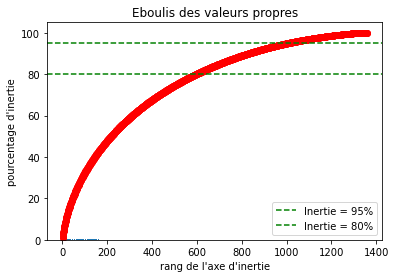

In [35]:
display_scree_plot(pca)

##### A lecture du graphique de l'éboulis des valeurs propres de notre jeu de données X, nous devons réduire le nombre des features à environ 950 features au lieu des 1 358 features obtenues après la première création des Bag-of-Words :

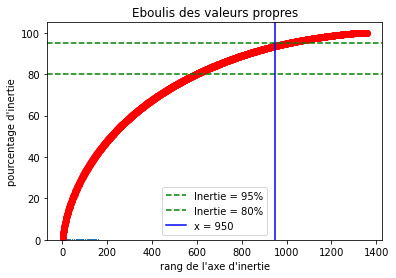

In [36]:
display_scree_plot_2(pca, 950)

###### Variable explicative `question_lemtokcl`, extraction de features avec le modèle Bag-of-Words :
- utilisation du module TfidfVectorizer de la librairie Scikit-Learn pour combiner le CountVectorizer et TfidfTransformer afin minimiser la redondance de certains mots en appliquant le modèle du Bag-of-Words tout en créant des n-grams de type (1,2) en réglant max_features à 950 features.  

In [37]:
vectorizer = TfidfVectorizer(
    analyzer="word",
    max_df=0.75, #ignore terms that have a document frequency strictly higher than 75 %
    min_df=0.0058, #ignore terms that have a document frequency strictly lower than 0,58 %
    tokenizer=None, #neutralize tokenization of words because is already done in the 1st part
    preprocessor=' '.join,
    stop_words=None, #neutralize remove of stop_words because is already done in the 1st part
    lowercase=False, #neutralize conversion in lowercase because is already done in the 1st part
    ngram_range = (1,2), #extract unigrams and bigrams
    max_features = 950
)
X = vectorizer.fit_transform(df.question_lemtokcl) #tfidf

In [38]:
vectorizer.get_feature_names() #visualisation des Bags-of-Words

['able',
 'accept',
 'access',
 'account',
 'achieve',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'add new',
 'address',
 'admin',
 'advance',
 'age',
 'ajax',
 'alert',
 'algorithm',
 'align',
 'alloc',
 'allow',
 'already',
 'also',
 'also try',
 'always',
 'amount',
 'android',
 'angular',
 'animation',
 'answer',
 'apache',
 'api',
 'app',
 'appear',
 'append',
 'application',
 'apply',
 'appreciate',
 'approach',
 'area',
 'args',
 'argument',
 'around',
 'array',
 'array array',
 'arraylist',
 'article',
 'ask',
 'asp',
 'aspdotnet',
 'aspx',
 'assembly',
 'asset',
 'assign',
 'assume',
 'async',
 'attempt',
 'attr',
 'attribute',
 'auth',
 'authentication',
 'author',
 'auto',
 'automatically',
 'available',
 'avoid',
 'await',
 'axis',
 'back',
 'background',
 'background color',
 'bad',
 'bar',
 'base',
 'bash',
 'basic',
 'basically',
 'batch',
 'become',
 'begin',
 'behavior',
 'big',
 'bin',
 'binary',
 'bind',
 'bit',
 'black',
 'blank',
 'block',


In [39]:
print("Shape of X : {}".format(X.shape)) #print the shape of X

Shape of X : (26208, 950)


In [40]:
# Materialize the sparse data
data_dense = X.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  3.419156866525288 %


In [41]:
joblib.dump(X,'le_X_vectorizer.pkl')

['le_X_vectorizer.pkl']

###### Encodage des  valeurs de la variable cible `tag_tok` : 

In [24]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df.tag_pop_tok)

In [25]:
print("Shape of y: {}".format(y.shape))

Shape of y: (26208, 124)


In [26]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
y1 = pd.DataFrame(mlb.fit_transform(df.tag_pop_norm.str.split(" ")),columns=mlb.classes_)
#pd.set_option("max_columns", y1.shape[1])
pd.set_option('display.max_columns', None)
print(display(y1.shape))
print(display(y1.head()))

(26208, 124)

None


,access,actionscript,ajax,algorithm,android,angular,angularjs,apache,api,arrays,aspnet,azure,bash,bootstrap,c,c++,class,cocoa,core,csharp,css,csv,data,database,dataframe,date,datetime,delphi,design,django,docker,dotnet,eclipse,excel,exception,facebook,file,flash,flutter,formicrosoft,framework,function,generics,git,google,hibernate,html,http,iis,image,interface,ios,iphone,java,javascript,jquery,json,laravel,linq,linux,list,macos,memory,microsoft,mongodb,multithreading,mvc,mysql,nodedotjs,numpy,objectivec,on,oop,oracle,pandas,parsing,performance,perl,php,postgresql,powershell,python,qt,r,rails,react,reactjs,regex,ruby,scala,security,selenium,server,services,shell,silverlight,spring,sql,sqlite,string,studio,svn,swift,swing,symfony,templates,testing,twitter,typescript,user,validation,vba,vbdotnet,visual,vuedotjs,wcf,web,windows,winformicrosoft,wordpress,wpf,x,xcode,xml
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


None


In [28]:
list_tags = y1.columns.tolist()
list_tags

['access',
 'actionscript',
 'ajax',
 'algorithm',
 'android',
 'angular',
 'angularjs',
 'apache',
 'api',
 'arrays',
 'aspnet',
 'azure',
 'bash',
 'bootstrap',
 'c',
 'c++',
 'class',
 'cocoa',
 'core',
 'csharp',
 'css',
 'csv',
 'data',
 'database',
 'dataframe',
 'date',
 'datetime',
 'delphi',
 'design',
 'django',
 'docker',
 'dotnet',
 'eclipse',
 'excel',
 'exception',
 'facebook',
 'file',
 'flash',
 'flutter',
 'formicrosoft',
 'framework',
 'function',
 'generics',
 'git',
 'google',
 'hibernate',
 'html',
 'http',
 'iis',
 'image',
 'interface',
 'ios',
 'iphone',
 'java',
 'javascript',
 'jquery',
 'json',
 'laravel',
 'linq',
 'linux',
 'list',
 'macos',
 'memory',
 'microsoft',
 'mongodb',
 'multithreading',
 'mvc',
 'mysql',
 'nodedotjs',
 'numpy',
 'objectivec',
 'on',
 'oop',
 'oracle',
 'pandas',
 'parsing',
 'performance',
 'perl',
 'php',
 'postgresql',
 'powershell',
 'python',
 'qt',
 'r',
 'rails',
 'react',
 'reactjs',
 'regex',
 'ruby',
 'scala',
 'security'

###### Création des jeux de dataset `train` et `test` pour la variable explicative et la variable cible :

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (18345, 950)
X_test shape : (7863, 950)
y_train shape : (18345, 124)
y_test shape : (7863, 124)


In [30]:
y_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [31]:
X_test

<7863x950 sparse matrix of type '<class 'numpy.float64'>'
	with 252678 stored elements in Compressed Sparse Row format>

In [32]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1,
                                                    test_size=0.3, random_state=42)
print("X_train shape : {}".format(X_train.shape))
print("X_test shape : {}".format(X_test.shape))
print("y_train shape : {}".format(y_train.shape))
print("y_test shape : {}".format(y_test.shape))

X_train shape : (18345, 950)
X_test shape : (7863, 950)
y_train shape : (18345, 124)
y_test shape : (7863, 124)


In [33]:
y1_test

,access,actionscript,ajax,algorithm,android,angular,angularjs,apache,api,arrays,aspnet,azure,bash,bootstrap,c,c++,class,cocoa,core,csharp,css,csv,data,database,dataframe,date,datetime,delphi,design,django,docker,dotnet,eclipse,excel,exception,facebook,file,flash,flutter,formicrosoft,framework,function,generics,git,google,hibernate,html,http,iis,image,interface,ios,iphone,java,javascript,jquery,json,laravel,linq,linux,list,macos,memory,microsoft,mongodb,multithreading,mvc,mysql,nodedotjs,numpy,objectivec,on,oop,oracle,pandas,parsing,performance,perl,php,postgresql,powershell,python,qt,r,rails,react,reactjs,regex,ruby,scala,security,selenium,server,services,shell,silverlight,spring,sql,sqlite,string,studio,svn,swift,swing,symfony,templates,testing,twitter,typescript,user,validation,vba,vbdotnet,visual,vuedotjs,wcf,web,windows,winformicrosoft,wordpress,wpf,x,xcode,xml
5787,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9736,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18572,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
X1_test

<7863x950 sparse matrix of type '<class 'numpy.float64'>'
	with 252678 stored elements in Compressed Sparse Row format>

### Méthode du LDA :
Dans le domaine du traitement automatique des langues, l’allocation de Dirichlet latente (de l’anglais Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste permettant d’expliquer des ensembles d’observations, par le moyen de groupes non observés, eux-mêmes définis par des similarités de données.
Pour chaque mot `w` de chaque document `d`, on calcule deux quantités pour chaque thème `t` : 

`p(t|d)` : la probabilité que le document `d` soit assigné au thème `t`.
`p(w|d)` : la probabilité que le thème `t` dans le corpus soit assigné au mot `w`.
On choisit alors le nouveau thème t avec la probabilité `p(t|d)` X `p(w|d)`. Ceci correspond à la probabilité que le thème `t` génère le mot `w` dans le document `d`.

En répétant les étapes précédentes un grand nombre de fois, les assignations se stabilisent. On obtient le mélange de thème présent dans chaque document en comptant chaque représentation d’un thème (assigné aux mots du document). On obtient les mots associés à chaque thème en comptant les mots qui y sont associés dans le corpus.

In [35]:
dict={}
for i in [2,6,10,14]:    
    lda =  LDA(n_components = i).fit(X)
    perp=lda.perplexity(X)
    dict[i]=perp

In [36]:
dict

{2: 821.1515939081213,
 6: 1146.7403334120277,
 10: 1372.538235601015,
 14: 1605.8696597482585}

In [37]:
dict2={}
for i in [2,6,10,14]:    
    lda =  LDA(n_components = i).fit(X)
    scor=lda.score(X)
    dict2[i]=scor

In [38]:
dict2

{2: -744583.5016281399,
 6: -781961.0815000284,
 10: -802704.9453935927,
 14: -817317.5380449286}

In [39]:
lda =  LDA(n_components = 10) #model construction with 10 topics wanted

In [40]:
lda.fit(X) #model compilation

LatentDirichletAllocation()

In [41]:
lda.perplexity(X) #calculate of the model's perplexity

1399.6470538214337

In [42]:
lda.score(X) #calculate of the model's score

-802853.7713403533

In [43]:
pyLDAvis.sklearn.prepare(lda, X, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.034815 -0.042639       1        1  13.122231
8     -0.112249 -0.027662       2        1  12.142870
0     -0.082861 -0.043267       3        1  11.910155
6     -0.119113 -0.075515       4        1  11.841218
4     -0.030819  0.185133       5        1  11.401548
9     -0.030885  0.087179       6        1  10.698953
5      0.079894 -0.071447       7        1   8.893153
2      0.128453  0.006252       8        1   7.222807
1      0.047126 -0.016802       9        1   6.797843
3      0.085639 -0.001232      10        1   5.969222, topic_info=        Term        Freq       Total Category  logprob  loglift
245      div  392.000000  392.000000  Default  30.0000  30.0000
325     file  831.000000  831.000000  Default  29.0000  29.0000
833    table  475.000000  475.000000  Default  28.0000  28.0000
808   string  643.000000  643.000000  Default  27.0000  27.0000
149   column  357.000000  357.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
297  example   42.531100  308.422242  Topic10  -5.0470   0.8373
916     want   50.748648  521.647626  Topic10  -4.8703   0.4884
889      use   58.470706  941.237969  Topic10  -4.7287   0.0399
871      try   39.886669  515.540979  Topic10  -5.1112   0.2594
143     code   38.967595  587.208005  Topic10  -5.1345   0.1059

[553 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
5         1  0.062633  action
5         2  0.109608  action
5         3  0.054804  action
5         4  0.054804  action
5         5  0.093950  action
...     ...       ...     ...
948       6  0.009247    year
948       7  0.147951    year
948       8  0.147951    year
948       9  0.490086    year
948      10  0.018494    year

[3315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 9, 1, 7, 5, 10, 6, 3, 2, 4])

In [44]:
number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(X)

print("Topics found via LDA:")
print_topics(lda, vectorizer, number_words)

Topics found via LDA:

Topic #0:
request user function json response log error url return get

Topic #1:
self cell android view image plot color layout frame screen

Topic #2:
div width button class image style css height text click

Topic #3:
int string public void array new return std class char

Topic #4:
form html input text php script type value jquery page

Topic #5:
use file application web server user good way project aspdotnet

Topic #6:
table date column query row select value sql name datum

Topic #7:
file run error java app use server thread android install

Topic #8:
file string line print python character use regex output number

Topic #9:
class object method public type use property string list function


#### Utilisation d'une méthode de "Fast LDA" :
- utilisation de LdaMulticore de la bibliothèque Gensim.

#### a. avec la variable `question_lemtokcl` sans preprocessing :

In [45]:
id2word = corpora.Dictionary(df.question_lemtokcl)

texts = df.question_lemtokcl
corpus = [id2word.doc2bow(text) for text in texts]

In [46]:
dict={}
for i in  np.arange(4,14,1) :
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=i, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df.question_lemtokcl, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    dict[i]=coherence_lda
    print('Coherence Score: ', coherence_lda)

Coherence Score:  0.46683914089029105
Coherence Score:  0.4767316069308382
Coherence Score:  0.5124231946388434
Coherence Score:  0.5019692703176333
Coherence Score:  0.5395660042148598
Coherence Score:  0.5053044486026688
Coherence Score:  0.5321807393385066
Coherence Score:  0.5151833483528118
Coherence Score:  0.5282955280607499
Coherence Score:  0.5170902439608618


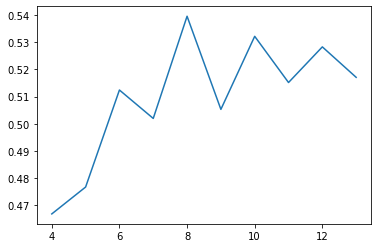

In [47]:
plt.plot(*zip(*sorted(dict.items())))
plt.show()

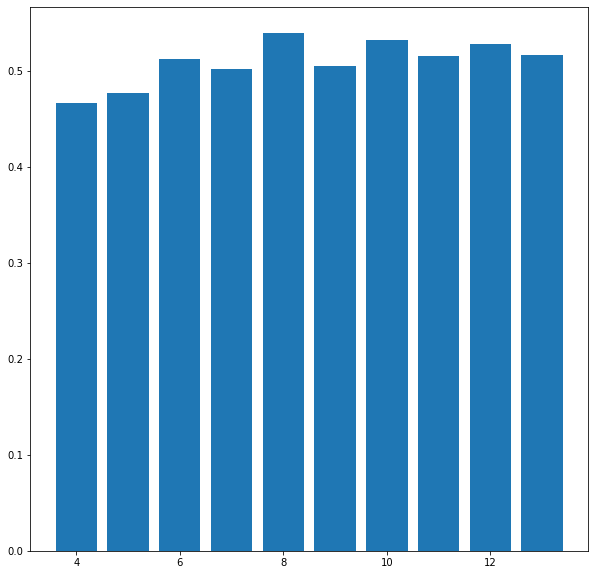

In [48]:
keys = dict.keys()
values = dict.values()

plt.figure(figsize=(10,10))
plt.bar(keys, values)
plt.show()

#### Modèle fastLDA avec 6 topics :

In [49]:
lda_model_6 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [50]:
vis_6 = pyLDAvis.gensim_models.prepare(lda_model_6, corpus, id2word)

In [51]:
vis_6

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.058078  0.100587       1        1  23.480595
3     -0.044187  0.130073       2        1  20.909990
4      0.047328  0.053868       3        1  19.127756
0     -0.093895 -0.009836       4        1  14.798375
1      0.284355 -0.069332       5        1  11.513294
5     -0.135523 -0.205361       6        1  10.169991, topic_info=         Term          Freq         Total Category  logprob  loglift
246       div   9994.000000   9994.000000  Default  30.0000  30.0000
30     string  12892.000000  12892.000000  Default  29.0000  29.0000
6770  android   5227.000000   5227.000000  Default  28.0000  28.0000
191     class  16701.000000  16701.000000  Default  27.0000  27.0000
37       file  16926.000000  16926.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
191     class   1203.798552  16701.119924   Topic6  -5.2605  -0.3443
1168   import   1020.061479   6326.239306   Topic6  -5.4261   0.4609
70     method    988.092262   5762.420627   Topic6  -5.4579   0.5224
32        use   1077.471286  24597.887009   Topic6  -5.3713  -0.8423
98        add    947.416336   7712.871693   Topic6  -5.5000   0.1888

[507 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2106       2  0.004004     abstract
2106       3  0.012011     abstract
2106       4  0.976922     abstract
2106       6  0.008008     abstract
13082      6  0.990391  activesheet
...      ...       ...          ...
9          1  0.046802         year
9          2  0.931028         year
9          3  0.005015         year
9          4  0.000836         year
9          6  0.016715         year

[1301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 1, 2, 6])

#### Modèle fastLDA avec 7 topics :

In [52]:
lda_model_7 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=7, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [53]:
vis_7 = pyLDAvis.gensim_models.prepare(lda_model_7, corpus, id2word)

In [54]:
vis_7

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.073607 -0.044957       1        1  17.917199
3     -0.045817  0.144983       2        1  17.673367
6     -0.090218 -0.093658       3        1  16.981061
2     -0.127902 -0.191526       4        1  14.277496
0     -0.037964  0.096910       5        1  12.495866
1      0.308746 -0.031386       6        1  10.536647
5     -0.080452  0.119634       7        1  10.118364, topic_info=         Term          Freq         Total Category  logprob  loglift
37       file  16497.000000  16497.000000  Default  30.0000  30.0000
246       div  10448.000000  10448.000000  Default  29.0000  29.0000
191     class  16799.000000  16799.000000  Default  28.0000  28.0000
30     string  13233.000000  13233.000000  Default  27.0000  27.0000
6770  android   6409.000000   6409.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
159    return   1345.347401  11989.985095   Topic7  -5.1442   0.1034
82     public   1211.745350   8144.002821   Topic7  -5.2488   0.3856
345     datum   1110.226462  12843.786625   Topic7  -5.3363  -0.1575
328     error   1008.984130  11590.035908   Topic7  -5.4319  -0.1504
148      null    947.193937   4789.700007   Topic7  -5.4951   0.6701

[586 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
2106       1  0.003373  abstract
2106       3  0.037098  abstract
2106       5  0.957791  abstract
15260      4  0.007616       ack
15260      7  0.990131       ack
...      ...       ...       ...
3791       6  0.977932       xsl
9          1  0.001725      year
9          2  0.825247      year
9          3  0.084508      year
9          7  0.087957      year

[1651 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 7, 3, 1, 2, 6])

#### Modèle fastLDA avec 8 topics :

In [55]:
lda_model_8 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [56]:
vis_8 = pyLDAvis.gensim_models.prepare(lda_model_8, corpus, id2word)

In [57]:
vis_8

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.065153 -0.043912       1        1  16.289752
3     -0.035855  0.152836       2        1  16.064401
4      0.115598 -0.003219       3        1  14.199766
0     -0.050625  0.122350       4        1  12.592139
2     -0.116645 -0.178310       5        1  11.569909
7     -0.058154 -0.150117       6        1  10.050848
1      0.313404 -0.024157       7        1   9.655302
5     -0.102570  0.124529       8        1   9.577883, topic_info=        Term          Freq         Total Category  logprob  loglift
37      file  16268.000000  16268.000000  Default  30.0000  30.0000
246      div  10159.000000  10159.000000  Default  29.0000  29.0000
30    string  13236.000000  13236.000000  Default  28.0000  28.0000
191    class  16973.000000  16973.000000  Default  27.0000  27.0000
420     user  11245.000000  11245.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
285     open    962.674870   2880.708531   Topic8  -5.4240   1.2496
159   return   1190.310163  12236.440378   Topic8  -5.2118   0.0155
1168  import    991.309595   6398.928382   Topic8  -5.3947   0.4809
345    datum    955.135077  13342.926921   Topic8  -5.4319  -0.2912
480     true    931.103485   5961.204133   Topic8  -5.4574   0.4891

[645 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
22030      8  0.992653      acc
875        1  0.003813  account
875        2  0.155385  account
875        5  0.040038  account
875        6  0.796944  account
...      ...       ...      ...
9          1  0.084337     year
9          2  0.889597     year
9          3  0.000811     year
9          8  0.024328     year
11698      3  0.995749  youtube

[1967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 5, 1, 3, 8, 2, 6])

#### Modèle fastLDA avec 10 topics :

In [58]:
lda_model_10 = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [59]:
vis_10 = pyLDAvis.gensim_models.prepare(lda_model_10, corpus, id2word)

In [60]:
vis_10

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.001319 -0.258056       1        1  14.385659
8      0.130347  0.014997       2        1  13.611748
2      0.116562  0.153273       3        1  11.508493
3      0.026297 -0.068663       4        1  11.266983
7      0.048043 -0.073674       5        1  10.473027
5      0.014970  0.062173       6        1   9.119300
9      0.064928 -0.055552       7        1   8.857720
0     -0.070541  0.051340       8        1   8.106193
6      0.008670  0.147399       9        1   7.161794
1     -0.340594  0.026763      10        1   5.509082, topic_info=           Term          Freq         Total Category  logprob  loglift
37         file  17011.000000  17011.000000  Default  30.0000  30.0000
82       public   8975.000000   8975.000000  Default  29.0000  29.0000
30       string  14002.000000  14002.000000  Default  28.0000  28.0000
246         div  10434.000000  10434.000000  Default  27.0000  27.0000
191       class  17684.000000  17684.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
20          get   1111.956028  17884.394076  Topic10  -4.7268   0.1210
2448          r    700.491842   3959.474999  Topic10  -5.1889   1.1667
162         set    757.800738   8204.671033  Topic10  -5.1102   0.5167
437   exception    585.752244   2249.021898  Topic10  -5.3678   1.5534
171         try    629.634809  13607.178255  Topic10  -5.2955  -0.1744

[782 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
26291     10  0.991533  abcdefg
22030      6  0.985635      acc
98         1  0.153755      add
98         2  0.219236      add
98         3  0.090082      add
...      ...       ...      ...
3421       4  0.991316     zero
5184       3  0.134770      zip
5184       5  0.012714      zip
5184       6  0.844220      zip
5184       7  0.005086      zip

[2520 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 3, 4, 8, 6, 10, 1, 7, 2])

### Méthodes Supervisées :

In [61]:
#dmy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
per = Perceptron()
#gbc = GradientBoostingClassifier()
#rfc = RandomForestClassifier()
svc = LinearSVC()
cmp = ComplementNB()

### Méthode Multi Output Classifier :

#### Modèle Linear SVC avec la méthode Multi Output Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [62]:
start_a = time.process_time()
multiclfsvc = MultiOutputClassifier(svc)
multiclfsvc.fit(X1_train, y1_train)
y_pred_multi_svc = multiclfsvc.predict(X1_test) 
end_a = time.process_time()
time_a = end_a - start_a 
print('Run Time :', time_a)

Run Time : 3.078125


In [63]:
metrics_svc_multiclass1 = metric_model('LinearSVC_multiClass_y1', y1_test, y_pred_multi_svc, time_a)
metrics_svc_multiclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125


In [64]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predmultisvc1 = mlb.inverse_transform(y_pred_multi_svc)

comparaison = pd.DataFrame(columns=['Test','Prediction_multi_svc_y1'])

comparaison['Test'] = test1
comparaison['Prediction_multi_svc_y1'] = predmultisvc1

comparaison.head(25)

,Test,Prediction_multi_svc_y1
0,"(mysql, php, sql)","(mysql,)"
1,"(on, rails, ruby)","(on, rails, ruby, wordpress)"
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(javascript, reactjs)"
5,"(csharp, dotnet, exception)","(csharp, dotnet)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)","(python,)"


In [65]:
vide = comparaison[comparaison['Prediction_multi_svc_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_1 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_1,'%')

Le taux de réponses nulles du modèle est de : 33.33333333333333 %


#### Modèle SGD Classifier avec la méthode Multi Output Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [66]:
start_b = time.process_time()
multiclfsgd = MultiOutputClassifier(sgd)
multiclfsgd.fit(X1_train, y1_train)
y_pred_multi_sgd = multiclfsgd.predict(X1_test) 
end_b = time.process_time()
time_b = end_b - start_b
print('Run Time :', time_b)

Run Time : 1.609375


In [67]:
metrics_sgd_multiclass1 = metric_model('SGDClass_multiClass_y1', y1_test, y_pred_multi_sgd, time_b)
metrics_sgd_multiclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
SGDClass_multiClass_y1,0.219382,0.613676,"(0.26971572183273623,)","(0.49441441441441447,)",0.323450,0.347769,0.686321,1.609375


In [68]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predmultisgd1 = mlb.inverse_transform(y_pred_multi_sgd)

comparaison = pd.DataFrame(columns=['Test','Prediction_multi_sgd_y1'])

comparaison['Test'] = test1
comparaison['Prediction_multi_sgd_y1'] = predmultisgd1

comparaison.head(25)

,Test,Prediction_multi_sgd_y1
0,"(mysql, php, sql)",()
1,"(on, rails, ruby)",()
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(reactjs,)"
5,"(csharp, dotnet, exception)","(csharp,)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)",()


In [69]:
vide = comparaison[comparaison['Prediction_multi_sgd_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_2 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_2,'%')

Le taux de réponses nulles du modèle est de : 43.99084318962228 %


#### Modèle Logistic Regression avec la méthode Multi Output Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [70]:
start_c = time.process_time()
multiclflr = MultiOutputClassifier(lr)
multiclflr.fit(X1_train, y1_train)
y_pred_multi_lr = multiclflr.predict(X1_test) 
end_c = time.process_time()
time_c = end_c - start_c
print('Run Time :', time_c)

Run Time : 8.3125


In [71]:
metrics_lr_multiclass1 = metric_model('LogisticRegression_multiClass_y1', y1_test, y_pred_multi_lr, time_c)
metrics_lr_multiclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LogisticRegression_multiClass_y1,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.312500


In [72]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predmultilr1 = mlb.inverse_transform(y_pred_multi_lr)

comparaison = pd.DataFrame(columns=['Test','Prediction_multi_lr_y1'])

comparaison['Test'] = test1
comparaison['Prediction_multi_lr_y1'] = predmultilr1

comparaison.head(25)

,Test,Prediction_multi_lr_y1
0,"(mysql, php, sql)",()
1,"(on, rails, ruby)",()
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(react, reactjs)"
5,"(csharp, dotnet, exception)","(csharp, dotnet)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)",()


In [73]:
vide = comparaison[comparaison['Prediction_multi_lr_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_3 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_3,'%')

Le taux de réponses nulles du modèle est de : 49.7647208444614 %


In [74]:
frame = [metrics_svc_multiclass1, metrics_sgd_multiclass1, metrics_lr_multiclass1]
tab_metrics_multiclass = pd.concat(frame)
tab_metrics_multiclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125
SGDClass_multiClass_y1,0.219382,0.613676,"(0.26971572183273623,)","(0.49441441441441447,)",0.323450,0.347769,0.686321,1.609375
LogisticRegression_multiClass_y1,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.312500


### Méthode One VS Rest Classifier :

#### Modèle SGD Classifier avec la méthode One VS Rest Classifier et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [75]:
start0 = time.process_time()

In [76]:
clfsgd = OneVsRestClassifier(sgd)
clfsgd.fit(X_train, y_train)
y_pred_sgd = clfsgd.predict(X_test)   

In [77]:
end0 = time.process_time()
time0 = end0 - start0
print('Run Time :', time0)

Run Time : 1.65625


In [78]:
sgd_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_sgd)
sgd_1vsrest_f1_score = metrics.f1_score(y_pred_sgd, y_test, average='weighted')
sgd_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_sgd, average='weighted')
sgd_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_sgd, average='weighted')
sgd_1vsrest_precison = metrics.precision_score(y_test, y_pred_sgd, average='weighted')

In [79]:
metrics_sgd_1vsrclass = metric_model('SGDClass_1VsRestClass', y_test, y_pred_sgd, time0)
metrics_sgd_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass,0.219509,0.612251,"(0.27022788688135974,)","(0.49390338015125784,)",0.323080,0.347625,0.681627,1.656250


#### Modèle SGD Classifier avec la méthode One VS Rest Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [80]:
start00 = time.process_time()

In [81]:
clfsgd1 = OneVsRestClassifier(sgd)
clfsgd1.fit(X1_train, y1_train)
y_pred_sgd1 = clfsgd1.predict(X1_test)

In [82]:
end00 = time.process_time()
time00 = end00 - start00
print('Run Time :', time00)

Run Time : 1.734375


In [83]:
sgd_1vsrest_accuracy1 = metrics.accuracy_score(y1_test, y_pred_sgd1)
sgd_1vsrest_f1_score1 = metrics.f1_score(y_pred_sgd1, y1_test, average='weighted')
sgd_1vsrest_jaccards1 = metrics.jaccard_score(y1_test, y_pred_sgd1, average='weighted')
sgd_1vsrest_recallsc1 = metrics.recall_score(y1_test, y_pred_sgd1, average='weighted')
sgd_1vsrest_precison1 = metrics.precision_score(y1_test, y_pred_sgd1, average='weighted')

In [84]:
metrics_sgd_1vsrclass1 = metric_model('SGDClass_1VsRestClass_y1', y1_test, y_pred_sgd1, time00)
metrics_sgd_1vsrclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass_y1,0.218364,0.613809,"(0.27024391379963913,)","(0.49494171416833566,)",0.323771,0.349001,0.684351,1.734375


In [85]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsgd1 = mlb.inverse_transform(y_pred_sgd1)

comparaison = pd.DataFrame(columns=['Test','Prediction_sgd_y1'])

comparaison['Test'] = test1
comparaison['Prediction_sgd_y1'] = predsgd1

comparaison.head(25)

,Test,Prediction_sgd_y1
0,"(mysql, php, sql)",()
1,"(on, rails, ruby)",()
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(reactjs,)"
5,"(csharp, dotnet, exception)","(csharp,)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)",()


In [86]:
vide = comparaison[comparaison['Prediction_sgd_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_4 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_4,'%')

Le taux de réponses nulles du modèle est de : 43.77464072237059 %


#### Modèle Logistic Régression avec la méthode One VS Rest Classifier et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [87]:
start1 = time.process_time()

In [88]:
clflr = OneVsRestClassifier(lr)
clflr.fit(X_train, y_train)
y_pred_lr = clflr.predict(X_test) 

In [89]:
end1 = time.process_time()
time1 = end1 - start1
print('Run Time :', time1)

Run Time : 8.5625


In [90]:
lr_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_lr)
lr_1vsrest_f1_score = metrics.f1_score(y_pred_lr, y_test, average='weighted')
lr_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_lr, average='weighted')
lr_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_lr, average='weighted')
lr_1vsrest_precison = metrics.precision_score(y_test, y_pred_lr, average='weighted')

In [91]:
metrics_lr_1vsrclass = metric_model('LogisticReg_1VsRestClass', y_test, y_pred_lr, time1)
metrics_lr_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LogisticReg_1VsRestClass,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.562500


#### Modèle Logistic Régression avec la méthode One VS Rest Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [92]:
start11 = time.process_time()

In [93]:
clflr1 = OneVsRestClassifier(lr)
clflr1.fit(X1_train, y1_train)
y_pred_lr1 = clflr1.predict(X1_test) 

In [94]:
end11 = time.process_time()
time11 = end11 - start11
print('Run Time :', time11)

Run Time : 8.421875


In [95]:
lr_1vsrest_accuracy1 = metrics.accuracy_score(y1_test, y_pred_lr1)
lr_1vsrest_f1_score1 = metrics.f1_score(y_pred_lr1, y1_test, average='weighted')
lr_1vsrest_jaccards1 = metrics.jaccard_score(y1_test, y_pred_lr1, average='weighted')
lr_1vsrest_recallsc1 = metrics.recall_score(y1_test, y_pred_lr1, average='weighted')
lr_1vsrest_precison1 = metrics.precision_score(y1_test, y_pred_lr1, average='weighted')

In [96]:
metrics_lr_1vsrclass1 = metric_model('LogisticReg_1VsRestClass_y1', y1_test, y_pred_lr1, time11)
metrics_lr_1vsrclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LogisticReg_1VsRestClass_y1,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.421875


In [97]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predlr1 = mlb.inverse_transform(y_pred_lr1)

comparaison = pd.DataFrame(columns=['Test','Prediction_lr_y1'])

comparaison['Test'] = test1
comparaison['Prediction_lr_y1'] = predlr1

comparaison.head(25)

,Test,Prediction_lr_y1
0,"(mysql, php, sql)",()
1,"(on, rails, ruby)",()
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(react, reactjs)"
5,"(csharp, dotnet, exception)","(csharp, dotnet)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)",()


In [98]:
vide = comparaison[comparaison['Prediction_lr_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_5 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_5,'%')

Le taux de réponses nulles du modèle est de : 49.7647208444614 %


#### Modèle  Multinomial NB avec la méthode One VS Rest Classifier et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [99]:
start2 = time.process_time()

In [100]:
clfmn = OneVsRestClassifier(mn)
clfmn.fit(X_train, y_train)
y_pred_mn = clfmn.predict(X_test) 

In [101]:
end2 = time.process_time()
time2 = end2 - start2
print('Run Time :', time2)

Run Time : 0.703125


In [102]:
mn_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_mn)
mn_1vsrest_f1_score = metrics.f1_score(y_pred_mn, y_test, average='weighted')
mn_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_mn, average='weighted')
mn_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_mn, average='weighted')
mn_1vsrest_precison = metrics.precision_score(y_test, y_pred_mn, average='weighted')

In [103]:
metrics_mn_1vsrclass = metric_model('MultinomialNB _1VsRestClass', y_test, y_pred_mn, time2)
metrics_mn_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
MultinomialNB _1VsRestClass,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.703125


#### Modèle  Multinomial NB avec la méthode One VS Rest Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [104]:
start22 = time.process_time()

In [105]:
clfmn1 = OneVsRestClassifier(mn)
clfmn1.fit(X1_train, y1_train)
y_pred_mn1 = clfmn1.predict(X1_test)

In [106]:
end22 = time.process_time()
time22 = end22 - start22
print('Run Time :', time22)

Run Time : 0.734375


In [107]:
mn_1vsrest_accuracy1 = metrics.accuracy_score(y1_test, y_pred_mn1)
mn_1vsrest_f1_score1 = metrics.f1_score(y_pred_mn1, y1_test, average='weighted')
mn_1vsrest_jaccards1 = metrics.jaccard_score(y1_test, y_pred_mn1, average='weighted')
mn_1vsrest_recallsc1 = metrics.recall_score(y1_test, y_pred_mn1, average='weighted')
mn_1vsrest_precison1 = metrics.precision_score(y1_test, y_pred_mn1, average='weighted')

In [108]:
metrics_mn_1vsrclass1 = metric_model('MultinomialNB _1VsRestClass_y1', y1_test, y_pred_mn1, time22)
metrics_mn_1vsrclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
MultinomialNB _1VsRestClass_y1,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.734375


In [109]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predmn1 = mlb.inverse_transform(y_pred_mn1)

comparaison = pd.DataFrame(columns=['Test','Prediction_mn_y1'])

comparaison['Test'] = test1
comparaison['Prediction_mn_y1'] = predmn1

comparaison.head(25)

,Test,Prediction_mn_y1
0,"(mysql, php, sql)",()
1,"(on, rails, ruby)",()
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(javascript, reactjs)"
5,"(csharp, dotnet, exception)",()
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)",()
9,"(python,)",()


In [110]:
vide = comparaison[comparaison['Prediction_mn_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_6 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_6,'%')

Le taux de réponses nulles du modèle est de : 78.60867353427446 %


#### Modèle  Perceptron avec la méthode One VS Rest Classifier et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [111]:
start3 = time.process_time()

In [112]:
clfper = OneVsRestClassifier(per)
clfper.fit(X_train, y_train)
y_pred_per = clfper.predict(X_test) 

In [113]:
end3 = time.process_time()
time3 = end3 - start3
print('Run Time :', time3)

Run Time : 1.390625


In [114]:
per_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_per)
per_1vsrest_f1_score = metrics.f1_score(y_pred_per, y_test, average='weighted')
per_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_per, average='weighted')
per_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_per, average='weighted')
per_1vsrest_precison = metrics.precision_score(y_test, y_pred_per, average='weighted')

In [115]:
metrics_per_1vsrclass = metric_model('Perceptron_1VsRestClass', y_test, y_pred_per, time3)
metrics_per_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
Perceptron_1VsRestClass,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.390625


#### Modèle  Perceptron avec la méthode One VS Rest Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [116]:
start33 = time.process_time()

In [117]:
clfper1 = OneVsRestClassifier(per)
clfper1.fit(X1_train, y1_train)
y_pred_per1 = clfper1.predict(X1_test)

In [118]:
end33 = time.process_time()
time33 = end33 - start33
print('Run Time :', time33)

Run Time : 1.484375


In [119]:
per_1vsrest_accuracy1 = metrics.accuracy_score(y1_test, y_pred_per1)
per_1vsrest_f1_score1 = metrics.f1_score(y_pred_per1, y1_test, average='weighted')
per_1vsrest_jaccards1 = metrics.jaccard_score(y1_test, y_pred_per1, average='weighted')
per_1vsrest_recallsc1 = metrics.recall_score(y1_test, y_pred_per1, average='weighted')
per_1vsrest_precison1 = metrics.precision_score(y1_test, y_pred_per1, average='weighted')

In [120]:
metrics_per_1vsrclass1 = metric_model('Perceptron_1VsRestClass_y1', y1_test, y_pred_per1, time33)
metrics_per_1vsrclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
Perceptron_1VsRestClass_y1,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.484375


In [121]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predper1 = mlb.inverse_transform(y_pred_per1)

comparaison = pd.DataFrame(columns=['Test','Prediction_per_y1'])

comparaison['Test'] = test1
comparaison['Prediction_per_y1'] = predper1

comparaison.head(25)

,Test,Prediction_per_y1
0,"(mysql, php, sql)","(database, laravel, mysql)"
1,"(on, rails, ruby)","(on, rails, ruby, wordpress)"
2,"(csharp, dotnet, html, vbdotnet)","(dotnet, winformicrosoft)"
3,"(csharp, date)","(c, dotnet)"
4,"(javascript, reactjs)","(javascript, reactjs)"
5,"(csharp, dotnet, exception)","(csharp, exception)"
6,"(winformicrosoft,)",()
7,"(perl,)","(nodedotjs, testing, windows)"
8,"(vba,)","(vba, vbdotnet)"
9,"(python,)","(x,)"


In [122]:
vide = comparaison[comparaison['Prediction_per_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_7 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_7,'%')

Le taux de réponses nulles du modèle est de : 12.844970113188351 %


#### Modèle  Linear SVC avec la méthode One VS Rest Classifier et le jeu de données ( X_train, X_test, y_train, y_test )  :

In [123]:
start4 = time.process_time()

In [124]:
clfsvc = OneVsRestClassifier(svc)
clfsvc.fit(X_train, y_train)
y_pred_svc = clfsvc.predict(X_test)

In [125]:
end4 = time.process_time()
time4 = end4 - start4
print('Run Time :', time4)

Run Time : 3.109375


In [126]:
svc_1vsrest_accuracy = metrics.accuracy_score(y_test, y_pred_svc)
svc_1vsrest_f1_score = metrics.f1_score(y_pred_svc, y_test, average='weighted')
svc_1vsrest_jaccards = metrics.jaccard_score(y_test, y_pred_svc, average='weighted')
svc_1vsrest_recallsc = metrics.recall_score(y_test, y_pred_svc, average='weighted')
svc_1vsrest_precison = metrics.precision_score(y_test, y_pred_svc, average='weighted')

In [127]:
metrics_svc_1vsrclass = metric_model('LinearSVC_1VsRestClass', y_test, y_pred_svc, time4)
metrics_svc_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375


#### Modèle  Linear SVC avec la méthode One VS Rest Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test )  :

In [128]:
start44 = time.process_time()

In [129]:
clfsvc1 = OneVsRestClassifier(svc)
clfsvc1.fit(X1_train, y1_train)
y_pred_svc1 = clfsvc1.predict(X1_test)

In [130]:
end44 = time.process_time()
time44 = end44 - start44
print('Run Time :', time44)

Run Time : 3.125


In [131]:
svc_1vsrest_accuracy1 = metrics.accuracy_score(y1_test, y_pred_svc1)
svc_1vsrest_f1_score1 = metrics.f1_score(y_pred_svc1, y1_test, average='weighted')
svc_1vsrest_jaccards1 = metrics.jaccard_score(y1_test, y_pred_svc1, average='weighted')
svc_1vsrest_recallsc1 = metrics.recall_score(y1_test, y_pred_svc1, average='weighted')
svc_1vsrest_precison1 = metrics.precision_score(y1_test, y_pred_svc1, average='weighted')

In [132]:
metrics_svc_1vsrclass1 = metric_model('LinearSVC_1VsRestClass_y1', y1_test, y_pred_svc1, time44)
metrics_svc_1vsrclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000


In [133]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsvc1 = mlb.inverse_transform(y_pred_svc1)

comparaison = pd.DataFrame(columns=['Test','Prediction_svc_y1'])

comparaison['Test'] = test1
comparaison['Prediction_svc_y1'] = predsvc1

comparaison.head(25)

,Test,Prediction_svc_y1
0,"(mysql, php, sql)","(mysql,)"
1,"(on, rails, ruby)","(on, rails, ruby, wordpress)"
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(javascript, reactjs)"
5,"(csharp, dotnet, exception)","(csharp, dotnet)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)","(python,)"


In [134]:
vide = comparaison[comparaison['Prediction_svc_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_8 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_8,'%')

Le taux de réponses nulles du modèle est de : 33.33333333333333 %


#### Confrontation des métriques des modèles avec la méthode One VS Rest Classifier et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [135]:
frames = [metrics_sgd_1vsrclass, metrics_lr_1vsrclass, metrics_mn_1vsrclass, metrics_per_1vsrclass, metrics_svc_1vsrclass]
tab_metrics_1vsrclass = pd.concat(frames)
tab_metrics_1vsrclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass,0.219509,0.612251,"(0.27022788688135974,)","(0.49390338015125784,)",0.323080,0.347625,0.681627,1.656250
LogisticReg_1VsRestClass,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.562500
MultinomialNB _1VsRestClass,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.703125
Perceptron_1VsRestClass,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.390625
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375


#### Confrontation des métriques des modèles avec la méthode One VS Rest Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [136]:
frames1 = [metrics_sgd_1vsrclass1, metrics_lr_1vsrclass1, metrics_mn_1vsrclass1, metrics_per_1vsrclass1, metrics_svc_1vsrclass1]
tab_metrics_1vsrclass1 = pd.concat(frames1)
tab_metrics_1vsrclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass_y1,0.218364,0.613809,"(0.27024391379963913,)","(0.49494171416833566,)",0.323771,0.349001,0.684351,1.734375
LogisticReg_1VsRestClass_y1,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.421875
MultinomialNB _1VsRestClass_y1,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.734375
Perceptron_1VsRestClass_y1,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.484375
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000


#### Confrontation des métriques des modèles avec la méthode One VS Rest Classifier et les jeux de données ( X_train, X_test, y_train, y_test ) et ( X1_train, X1_test, y1_train, y1_test ) :

In [137]:
frames2 = [metrics_sgd_1vsrclass, metrics_lr_1vsrclass, metrics_mn_1vsrclass, metrics_per_1vsrclass, metrics_svc_1vsrclass, metrics_sgd_1vsrclass1, metrics_lr_1vsrclass1, metrics_mn_1vsrclass1, metrics_per_1vsrclass1, metrics_svc_1vsrclass1]
tab_metrics_1vsrclass_tot = pd.concat(frames2)
tab_metrics_1vsrclass_tot.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass,0.219509,0.612251,"(0.27022788688135974,)","(0.49390338015125784,)",0.323080,0.347625,0.681627,1.656250
LogisticReg_1VsRestClass,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.562500
MultinomialNB _1VsRestClass,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.703125
Perceptron_1VsRestClass,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.390625
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
SGDClass_1VsRestClass_y1,0.218364,0.613809,"(0.27024391379963913,)","(0.49494171416833566,)",0.323771,0.349001,0.684351,1.734375
LogisticReg_1VsRestClass_y1,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.421875
MultinomialNB _1VsRestClass_y1,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.734375
Perceptron_1VsRestClass_y1,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.484375
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000


### Méthode Classifier Chain:

#### Modèle  Multinomial NB avec la méthode Classifier Chain et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [138]:
start_mnbcc = time.process_time()
chnmn = ClassifierChain(mn, order='random', random_state=0)
chnmn.fit(X_train, y_train)
y_pred_chnmn = chnmn.predict(X_test)
end_mnbcc = time.process_time()
time_mnbcc = end_mnbcc - start_mnbcc
print('Run Time :', time_mnbcc)

Run Time : 2.859375


In [139]:
mn_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chnmn)
mn_chn_f1_score = metrics.f1_score(y_pred_chnmn, y_test, average='weighted')
mn_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chnmn, average='weighted')
mn_chn_recallsc = metrics.recall_score(y_test, y_pred_chnmn, average='weighted')
mn_chn_precison = metrics.precision_score(y_test, y_pred_chnmn, average='weighted')
metrics_mn_chn = metric_model('MultinomialNB_ClassChain', y_test, y_pred_chnmn, time_mnbcc)
metrics_mn_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
MultinomialNB_ClassChain,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375


#### Modèle  Multinomial NB avec la méthode Classifier Chain et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [140]:
start_mnbcc1 = time.process_time()
chnmn1 = ClassifierChain(mn, order='random', random_state=0)
chnmn1.fit(X1_train, y1_train)
y_pred_chnmn1 = chnmn1.predict(X1_test)
end_mnbcc1 = time.process_time()
time_mnbcc1 = end_mnbcc1 - start_mnbcc1
print('Run Time :', time_mnbcc1)

Run Time : 3.046875


In [141]:
mn_chn_accuracy1 = metrics.accuracy_score(y1_test, y_pred_chnmn1)
mn_chn_f1_score1 = metrics.f1_score(y_pred_chnmn1, y1_test, average='weighted')
mn_chn_jaccards1 = metrics.jaccard_score(y1_test, y_pred_chnmn1, average='weighted')
mn_chn_recallsc1 = metrics.recall_score(y1_test, y_pred_chnmn1, average='weighted')
mn_chn_precison1 = metrics.precision_score(y1_test, y_pred_chnmn1, average='weighted')
metrics_mn_chn1 = metric_model('MultinomialNB_ClassChain_y1', y1_test, y_pred_chnmn1, time_mnbcc)
metrics_mn_chn1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
MultinomialNB_ClassChain_y1,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375


In [142]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predchnmn1 = mlb.inverse_transform(y_pred_chnmn1)

comparaison = pd.DataFrame(columns=['Test','Prediction_chnmn_y1'])

comparaison['Test'] = test1
comparaison['Prediction_chnmn_y1'] = predchnmn1

comparaison.head(25)

,Test,Prediction_chnmn_y1
0,"(mysql, php, sql)",()
1,"(on, rails, ruby)",()
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(javascript, react, reactjs)"
5,"(csharp, dotnet, exception)","(csharp,)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)",()
9,"(python,)",()


In [143]:
vide = comparaison[comparaison['Prediction_chnmn_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_9 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_9,'%')

Le taux de réponses nulles du modèle est de : 71.53758107592522 %


#### Modèle Complement NB avec la méthode Classifier Chain et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [144]:
start_cnbcc = time.process_time()
chncmp = ClassifierChain(cmp, order='random', random_state=0)
chncmp.fit(X_train, y_train)
y_pred_chncmp = chncmp.predict(X_test)
end_cnbcc = time.process_time()
time_cnbcc = end_cnbcc - start_cnbcc
print('Run Time :', time_cnbcc)

Run Time : 3.171875


In [145]:
cmp_chn_accuracy = metrics.accuracy_score(y_test, y_pred_chncmp)
cmp_chn_f1_score = metrics.f1_score(y_pred_chncmp, y_test, average='weighted')
cmp_chn_jaccards = metrics.jaccard_score(y_test, y_pred_chncmp, average='weighted')
cmp_chn_recallsc = metrics.recall_score(y_test, y_pred_chncmp, average='weighted')
cmp_chn_precison = metrics.precision_score(y_test, y_pred_chncmp, average='weighted')
metrics_cmp_chn = metric_model('ComplementNB_ClassChain', y_test, y_pred_chncmp, time_cnbcc)
metrics_cmp_chn.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
ComplementNB_ClassChain,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.171875


#### Modèle Complement NB avec la méthode Classifier Chain et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [146]:
start_cnbcc1 = time.process_time()
chncmp1 = ClassifierChain(cmp, order='random', random_state=0)
chncmp1.fit(X1_train, y1_train)
y_pred_chncmp1 = chncmp1.predict(X1_test)
end_cnbcc1 = time.process_time()
time_cnbcc1 = end_cnbcc1 - start_cnbcc1
print('Run Time :', time_cnbcc1)

Run Time : 3.15625


In [147]:
cmp_chn_accuracy1 = metrics.accuracy_score(y1_test, y_pred_chncmp1)
cmp_chn_f1_score1 = metrics.f1_score(y_pred_chncmp1, y1_test, average='weighted')
cmp_chn_jaccards1 = metrics.jaccard_score(y1_test, y_pred_chncmp1, average='weighted')
cmp_chn_recallsc1 = metrics.recall_score(y1_test, y_pred_chncmp1, average='weighted')
cmp_chn_precison1 = metrics.precision_score(y1_test, y_pred_chncmp1, average='weighted')
metrics_cmp_chn1 = metric_model('ComplementNB_ClassChain_y1', y1_test, y_pred_chncmp1, time_cnbcc1)
metrics_cmp_chn1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
ComplementNB_ClassChain_y1,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.156250


In [148]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predchncmp1 = mlb.inverse_transform(y_pred_chncmp1)

comparaison = pd.DataFrame(columns=['Test','Prediction_chncmp_y1'])

comparaison['Test'] = test1
comparaison['Prediction_chncmp_y1'] = predchncmp1

comparaison.head(25)

,Test,Prediction_chncmp_y1
0,"(mysql, php, sql)","(access, api, csv, database, excel, microsoft,..."
1,"(on, rails, ruby)","(angular, javascript, nodedotjs, react, reactj..."
2,"(csharp, dotnet, html, vbdotnet)","(aspnet, csharp, dotnet, iis, linq, mvc, vbdot..."
3,"(csharp, date)","(aspnet, csharp, dotnet, framework, iis, linq,..."
4,"(javascript, reactjs)","(angular, api, bootstrap, css, html, javascrip..."
5,"(csharp, dotnet, exception)","(class, csharp, dotnet, exception, interface, ..."
6,"(winformicrosoft,)","(access, csv, dataframe, excel, pandas, python..."
7,"(perl,)","(actionscript, apache, flash, http, scala)"
8,"(vba,)","(access, csv, excel, file, microsoft, vba, vbd..."
9,"(python,)","(css, formicrosoft, html, javascript, jquery)"


In [149]:
vide = comparaison[comparaison['Prediction_chncmp_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t_10 = (a/b)*100
print('Le taux de réponses nulles du modèle est de :', t_10,'%')

Le taux de réponses nulles du modèle est de : 0.012717792191275595 %


#### Confrontation des métriques des modèles avec la méthode Classifier Chain et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [150]:
frames3 = [metrics_cmp_chn, metrics_mn_chn]
tab_metrics_chnclass = pd.concat(frames3)
tab_metrics_chnclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
ComplementNB_ClassChain,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.171875
MultinomialNB_ClassChain,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375


#### Confrontation des métriques des modèles avec la méthode Classifier Chain et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [151]:
frames4 = [metrics_cmp_chn1, metrics_mn_chn1]
tab_metrics_chnclass1 = pd.concat(frames4)
tab_metrics_chnclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
ComplementNB_ClassChain_y1,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.156250
MultinomialNB_ClassChain_y1,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375


#### Confrontation des métriques des modèles avec la méthode Classifier Chain et les jeux de données ( X_train, X_test, y_train, y_test ) et ( X1_train, X1_test, y1_train, y1_test ) :

In [152]:
frames5 = [tab_metrics_chnclass, tab_metrics_chnclass1]
tab_metrics_chnclass_tot = pd.concat(frames5)
tab_metrics_chnclass_tot.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
ComplementNB_ClassChain,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.171875
MultinomialNB_ClassChain,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375
ComplementNB_ClassChain_y1,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.156250
MultinomialNB_ClassChain_y1,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375


#### Confrontation des métriques des modèles avec les méthodes One VS Rest Classifier et Classifier Chain et le jeu de données ( X_train, X_test, y_train, y_test ) :

In [153]:
frames5 = [metrics_sgd_1vsrclass, metrics_lr_1vsrclass, metrics_mn_1vsrclass, metrics_per_1vsrclass, metrics_svc_1vsrclass, metrics_cmp_chn, metrics_mn_chn]
tab_metrics_1vsrchnclass = pd.concat(frames5)
tab_metrics_1vsrchnclass.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass,0.219509,0.612251,"(0.27022788688135974,)","(0.49390338015125784,)",0.323080,0.347625,0.681627,1.656250
LogisticReg_1VsRestClass,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.562500
MultinomialNB _1VsRestClass,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.703125
Perceptron_1VsRestClass,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.390625
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
ComplementNB_ClassChain,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.171875
MultinomialNB_ClassChain,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375


#### Confrontation des métriques des modèles avec les méthodes Multi Output Classifier, One VS Rest Classifier et Classifier Chain et le jeu de données ( X1_train, X1_test, y1_train, y1_test ) :

In [154]:
frames6 = [metrics_svc_multiclass1, metrics_sgd_multiclass1, metrics_lr_multiclass1, metrics_sgd_1vsrclass1, metrics_lr_1vsrclass1, metrics_mn_1vsrclass1, metrics_per_1vsrclass1, metrics_svc_1vsrclass1, metrics_cmp_chn1, metrics_mn_chn1]
tab_metrics_1vsrchnclass1 = pd.concat(frames6)
tab_metrics_1vsrchnclass1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125
SGDClass_multiClass_y1,0.219382,0.613676,"(0.26971572183273623,)","(0.49441441441441447,)",0.323450,0.347769,0.686321,1.609375
LogisticRegression_multiClass_y1,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.312500
SGDClass_1VsRestClass_y1,0.218364,0.613809,"(0.27024391379963913,)","(0.49494171416833566,)",0.323771,0.349001,0.684351,1.734375
LogisticReg_1VsRestClass_y1,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.421875
MultinomialNB _1VsRestClass_y1,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.734375
Perceptron_1VsRestClass_y1,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.484375
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000
ComplementNB_ClassChain_y1,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.156250
MultinomialNB_ClassChain_y1,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375


#### Confrontation des métriques des modèles avec les méthodes Multi Output Classifier, One VS Rest Classifier et Classifier Chain et et les jeux de données ( X_train, X_test, y_train, y_test ) et ( X1_train, X1_test, y1_train, y1_test ) :

In [155]:
frames7 = [tab_metrics_1vsrchnclass, tab_metrics_1vsrchnclass1]
tab_metrics_1vsrchnclass_tot = pd.concat(frames7)
tab_metrics_1vsrchnclass_tot.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
SGDClass_1VsRestClass,0.219509,0.612251,"(0.27022788688135974,)","(0.49390338015125784,)",0.323080,0.347625,0.681627,1.656250
LogisticReg_1VsRestClass,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.562500
MultinomialNB _1VsRestClass,0.067404,0.405572,"(0.07239939598569518,)","(0.2272221535418469,)",0.122387,0.133111,0.548545,0.703125
Perceptron_1VsRestClass,0.153631,0.440573,"(0.3422211939158581,)","(0.447454076097123,)",0.312299,0.433082,0.490590,1.390625
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
ComplementNB_ClassChain,0.001017,0.165594,"(0.16397387686250436,)","(0.18767099975127308,)",0.178783,0.519119,0.241034,3.171875
MultinomialNB_ClassChain,0.083047,0.432142,"(0.11062797166656929,)","(0.2968837261253211,)",0.163844,0.192497,0.567735,2.859375
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125
SGDClass_multiClass_y1,0.219382,0.613676,"(0.26971572183273623,)","(0.49441441441441447,)",0.323450,0.347769,0.686321,1.609375
LogisticRegression_multiClass_y1,0.186570,0.537518,"(0.25313920500263964,)","(0.45007388642600804,)",0.287909,0.308806,0.748492,8.312500


In [156]:
tab_metrics_tot = tab_metrics_1vsrchnclass_tot.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')
dfi.export(tab_metrics_tot, 'tab_metrics_tot.png')  

### Confrontation des meilleurs modèles et sélection du meilleur modèle :

In [157]:
frames8 = [metrics_svc_1vsrclass1, metrics_svc_1vsrclass, metrics_svc_multiclass1]
tab_metrics_fin = pd.concat(frames8)
tab_metrics_fin.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125


In [158]:
tab_metrics_best_model = tab_metrics_best_model = tab_metrics_fin.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')
dfi.export(tab_metrics_best_model, 'tab_metrics_best_model.png') 

Le meilleur modèle est le modèle Linear SVC utilisant la méthode One Versus Rest Classifier et le jeu de données ( X1_train, X1_test, y1_train, y1_test ).

#### Tags prédits comparés aux tags témoins du modèle Multi Output Classifier Linear SVC.

In [159]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predmultisvc1 = mlb.inverse_transform(y_pred_multi_svc)

comparaison = pd.DataFrame(columns=['Test','Predictions_multi_svc_y1'])

comparaison['Test'] = test1
comparaison['Predictions_multi_svc_y1'] = predmultisvc1
pd.set_option('display.max_rows', None)
comparaison.head(30)

,Test,Predictions_multi_svc_y1
0,"(mysql, php, sql)","(mysql,)"
1,"(on, rails, ruby)","(on, rails, ruby, wordpress)"
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(javascript, reactjs)"
5,"(csharp, dotnet, exception)","(csharp, dotnet)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)","(python,)"


In [160]:
compar_tags = comparaison.head(30)
compar_tags = pd.DataFrame(compar_tags) 
dfi.export(compar_tags, 'compar_tags.png')

In [161]:
vide = comparaison[comparaison['Predictions_multi_svc_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
tmultisvc = (a/b)*100
print('Le taux de réponses nulles du modèle Multi Output Classifier Linear SVC est de :', tmultisvc,'%')

Le taux de réponses nulles du modèle Multi Output Classifier Linear SVC est de : 33.33333333333333 %


In [162]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsvc1 = mlb.inverse_transform(y_pred_svc1)

comparaison = pd.DataFrame(columns=['Test','Prediction_svc_y1'])

comparaison['Test'] = test1
comparaison['Prediction_svc_y1'] = predsvc1

comparaison.head(25)

,Test,Prediction_svc_y1
0,"(mysql, php, sql)","(mysql,)"
1,"(on, rails, ruby)","(on, rails, ruby, wordpress)"
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(javascript, reactjs)"
5,"(csharp, dotnet, exception)","(csharp, dotnet)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)","(python,)"


In [163]:
vide = comparaison[comparaison['Prediction_svc_y1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
t1vrestsvc = (a/b)*100
print('Le taux de réponses nulles du modèle OneVRest Classifier Linear SVC est de :', t1vrestsvc,'%')

Le taux de réponses nulles du modèle OneVRest Classifier Linear SVC est de : 33.33333333333333 %


#### Optimisation par Grid Search du meilleur modèle :

In [164]:
svc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [165]:
OneVsRestClassifier(estimator=LinearSVC()).estimator.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

#### Optimisation 1 avec 1ère grille de paramètres :

In [166]:
param_grid = {'estimator__C':[1,2,10], 'estimator__max_iter':[5, 10, 50, 100, 500, 1000], 'estimator__random_state':[None, 42]}

In [167]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5, verbose=10)

In [168]:
CV_svc.fit(X1_train, y1_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START estimator__C=1, estimator__max_iter=5, estimator__random_state=None
[CV 1/5; 1/36] END estimator__C=1, estimator__max_iter=5, estimator__random_state=None;, score=0.238 total time=   1.4s
[CV 2/5; 1/36] START estimator__C=1, estimator__max_iter=5, estimator__random_state=None
[CV 2/5; 1/36] END estimator__C=1, estimator__max_iter=5, estimator__random_state=None;, score=0.233 total time=   1.4s
[CV 3/5; 1/36] START estimator__C=1, estimator__max_iter=5, estimator__random_state=None
[CV 3/5; 1/36] END estimator__C=1, estimator__max_iter=5, estimator__random_state=None;, score=0.227 total time=   1.4s
[CV 4/5; 1/36] START estimator__C=1, estimator__max_iter=5, estimator__random_state=None
[CV 4/5; 1/36] END estimator__C=1, estimator__max_iter=5, estimator__random_state=None;, score=0.238 total time=   1.4s
[CV 5/5; 1/36] START estimator__C=1, estimator__max_iter=5, estimator__random_state=None
[CV 5/5; 1/36

[CV 5/5; 8/36] END estimator__C=1, estimator__max_iter=100, estimator__random_state=42;, score=0.231 total time=   2.3s
[CV 1/5; 9/36] START estimator__C=1, estimator__max_iter=500, estimator__random_state=None
[CV 1/5; 9/36] END estimator__C=1, estimator__max_iter=500, estimator__random_state=None;, score=0.243 total time=   2.3s
[CV 2/5; 9/36] START estimator__C=1, estimator__max_iter=500, estimator__random_state=None
[CV 2/5; 9/36] END estimator__C=1, estimator__max_iter=500, estimator__random_state=None;, score=0.238 total time=   2.3s
[CV 3/5; 9/36] START estimator__C=1, estimator__max_iter=500, estimator__random_state=None
[CV 3/5; 9/36] END estimator__C=1, estimator__max_iter=500, estimator__random_state=None;, score=0.241 total time=   2.2s
[CV 4/5; 9/36] START estimator__C=1, estimator__max_iter=500, estimator__random_state=None
[CV 4/5; 9/36] END estimator__C=1, estimator__max_iter=500, estimator__random_state=None;, score=0.240 total time=   2.2s
[CV 5/5; 9/36] START estimat

[CV 4/5; 16/36] END estimator__C=2, estimator__max_iter=10, estimator__random_state=42;, score=0.239 total time=   1.7s
[CV 5/5; 16/36] START estimator__C=2, estimator__max_iter=10, estimator__random_state=42
[CV 5/5; 16/36] END estimator__C=2, estimator__max_iter=10, estimator__random_state=42;, score=0.230 total time=   1.7s
[CV 1/5; 17/36] START estimator__C=2, estimator__max_iter=50, estimator__random_state=None
[CV 1/5; 17/36] END estimator__C=2, estimator__max_iter=50, estimator__random_state=None;, score=0.244 total time=   2.2s
[CV 2/5; 17/36] START estimator__C=2, estimator__max_iter=50, estimator__random_state=None
[CV 2/5; 17/36] END estimator__C=2, estimator__max_iter=50, estimator__random_state=None;, score=0.234 total time=   2.3s
[CV 3/5; 17/36] START estimator__C=2, estimator__max_iter=50, estimator__random_state=None
[CV 3/5; 17/36] END estimator__C=2, estimator__max_iter=50, estimator__random_state=None;, score=0.239 total time=   2.2s
[CV 4/5; 17/36] START estimator_

[CV 3/5; 24/36] END estimator__C=2, estimator__max_iter=1000, estimator__random_state=42;, score=0.239 total time=   2.7s
[CV 4/5; 24/36] START estimator__C=2, estimator__max_iter=1000, estimator__random_state=42
[CV 4/5; 24/36] END estimator__C=2, estimator__max_iter=1000, estimator__random_state=42;, score=0.238 total time=   2.7s
[CV 5/5; 24/36] START estimator__C=2, estimator__max_iter=1000, estimator__random_state=42
[CV 5/5; 24/36] END estimator__C=2, estimator__max_iter=1000, estimator__random_state=42;, score=0.233 total time=   2.7s
[CV 1/5; 25/36] START estimator__C=10, estimator__max_iter=5, estimator__random_state=None
[CV 1/5; 25/36] END estimator__C=10, estimator__max_iter=5, estimator__random_state=None;, score=0.201 total time=   1.3s
[CV 2/5; 25/36] START estimator__C=10, estimator__max_iter=5, estimator__random_state=None
[CV 2/5; 25/36] END estimator__C=10, estimator__max_iter=5, estimator__random_state=None;, score=0.177 total time=   1.4s
[CV 3/5; 25/36] START esti

[CV 2/5; 32/36] END estimator__C=10, estimator__max_iter=100, estimator__random_state=42;, score=0.192 total time=   2.9s
[CV 3/5; 32/36] START estimator__C=10, estimator__max_iter=100, estimator__random_state=42
[CV 3/5; 32/36] END estimator__C=10, estimator__max_iter=100, estimator__random_state=42;, score=0.194 total time=   3.0s
[CV 4/5; 32/36] START estimator__C=10, estimator__max_iter=100, estimator__random_state=42
[CV 4/5; 32/36] END estimator__C=10, estimator__max_iter=100, estimator__random_state=42;, score=0.203 total time=   2.9s
[CV 5/5; 32/36] START estimator__C=10, estimator__max_iter=100, estimator__random_state=42
[CV 5/5; 32/36] END estimator__C=10, estimator__max_iter=100, estimator__random_state=42;, score=0.193 total time=   3.0s
[CV 1/5; 33/36] START estimator__C=10, estimator__max_iter=500, estimator__random_state=None
[CV 1/5; 33/36] END estimator__C=10, estimator__max_iter=500, estimator__random_state=None;, score=0.197 total time=   5.3s
[CV 2/5; 33/36] START 

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 2, 10],
                         'estimator__max_iter': [5, 10, 50, 100, 500, 1000],
                         'estimator__random_state': [None, 42]},
             verbose=10)

In [169]:
CV_svc.best_params_

{'estimator__C': 1, 'estimator__max_iter': 50, 'estimator__random_state': None}

In [170]:
best_model = CV_svc.best_estimator_

In [171]:
best_model

OneVsRestClassifier(estimator=LinearSVC(C=1, max_iter=50))

In [172]:
startbest = time.process_time()
y_pred_svc_bestmodel = best_model.predict(X1_test)
endbest = time.process_time()
timebest = endbest - startbest
print('Run Time :', timebest)

Run Time : 0.0625


In [173]:
best_model.score(X,y)

0.3386752136752137

In [174]:
best_model.decision_function(X)

array([[-1.70718714, -1.75470933, -0.99654955, ..., -1.87164769,
        -1.69994681, -1.2702223 ],
       [-1.34107771, -1.62050622, -2.17156859, ..., -1.71801392,
        -1.17682888, -0.83468748],
       [-0.83247321, -1.50491318, -1.43388576, ..., -1.81602888,
        -1.54246772, -0.9658666 ],
       ...,
       [-1.74933035, -1.61979374, -2.07907262, ..., -1.49786157,
        -0.89840437, -1.66891885],
       [-2.27518372, -1.1688646 , -2.07414835, ..., -1.15383883,
        -1.80600716, -1.52452336],
       [-1.3054221 , -1.3735284 , -2.19538657, ..., -1.05220618,
        -1.33338754, -1.70797576]])

In [175]:
metrics_svc_bestmodel = metric_model('LinearSVC_1VsRestClass_opt', y1_test, y_pred_svc_bestmodel, timebest)
metrics_svc_bestmodel.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,0.062500


In [176]:
frames9 = [metrics_svc_bestmodel, metrics_svc_1vsrclass1, metrics_svc_1vsrclass, metrics_svc_multiclass1]
tab_metrics_fin = pd.concat(frames9)
tab_metrics_fin.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,0.062500
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125


In [177]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsvc_bestmodel = mlb.inverse_transform(y_pred_svc_bestmodel)

comparaison = pd.DataFrame(columns=['Test','Prediction_svc_bestmodel'])

comparaison['Test'] = test1
comparaison['Prediction_svc_bestmodel'] = predsvc_bestmodel
pd.set_option('display.max_rows', None)
comparaison.sample(100)

,Test,Prediction_svc_bestmodel
3301,"(dotnet,)",()
1862,"(php, validation)","(php,)"
3332,"(framework,)","(php,)"
4758,"(python, regex)","(python,)"
6402,"(bash, shell)",()
3500,"(dataframe, pandas, python)","(pandas, python)"
581,"(reactjs,)","(javascript, reactjs)"
5576,"(windows,)","(windows,)"
4082,"(c++, database, templates)","(c++,)"
6627,"(mysql,)","(sql,)"


In [178]:
vide = comparaison[comparaison['Prediction_svc_bestmodel']==()]
a = vide.shape[0]
b = comparaison.shape[0]
tbestmodel = (a/b)*100
print('Le taux de réponses nulles du best modèle est de :', tbestmodel,'%')

Le taux de réponses nulles du best modèle est de : 33.33333333333333 %


#### Optimisation 2 avec 2nde grille de paramètres :

In [179]:
param_grid_1 = {'estimator__C':[1,5], 'estimator__max_iter':[100, 1000], 'estimator__random_state':[None, 42], 'estimator__intercept_scaling':[1,5], 'estimator__dual':[True, False]}

In [180]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc_1 = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid_1, cv= 5, verbose=10)

In [181]:
CV_svc_1.fit(X1_train, y1_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=100, estimator__random_state=None
[CV 1/5; 1/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=100, estimator__random_state=None;, score=0.243 total time=   2.2s
[CV 2/5; 1/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=100, estimator__random_state=None
[CV 2/5; 1/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=100, estimator__random_state=None;, score=0.238 total time=   2.2s
[CV 3/5; 1/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=100, estimator__random_state=None
[CV 3/5; 1/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=100, estimator__random_state=None;, score=

[CV 1/5; 6/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42;, score=0.246 total time=   8.3s
[CV 2/5; 6/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42
[CV 2/5; 6/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42;, score=0.238 total time=   8.4s
[CV 3/5; 6/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42
[CV 3/5; 6/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42;, score=0.241 total time=   8.3s
[CV 4/5; 6/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42
[CV 4/5; 6/32] END estimator__C=1, estimator__dua

[CV 2/5; 11/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None;, score=0.238 total time=   3.0s
[CV 3/5; 11/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None
[CV 3/5; 11/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None;, score=0.241 total time=   3.0s
[CV 4/5; 11/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None
[CV 4/5; 11/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None;, score=0.240 total time=   3.0s
[CV 5/5; 11/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None
[CV 5/5; 11/32] END

[CV 3/5; 16/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42;, score=0.241 total time=   3.5s
[CV 4/5; 16/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42
[CV 4/5; 16/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42;, score=0.239 total time=   3.5s
[CV 5/5; 16/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42
[CV 5/5; 16/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42;, score=0.230 total time=   3.6s
[CV 1/5; 17/32] START estimator__C=5, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=100, estimator__random_state=None
[CV 1/5; 17/32] END estimator__

[CV 4/5; 21/32] END estimator__C=5, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=None;, score=0.229 total time=   9.6s
[CV 5/5; 21/32] START estimator__C=5, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=None
[CV 5/5; 21/32] END estimator__C=5, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=None;, score=0.158 total time=   9.8s
[CV 1/5; 22/32] START estimator__C=5, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42
[CV 1/5; 22/32] END estimator__C=5, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42;, score=0.225 total time=   9.9s
[CV 2/5; 22/32] START estimator__C=5, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=100, estimator__random_state=42
[CV 2/5; 22/32] END estimator__C=5, e

[CV 5/5; 26/32] END estimator__C=5, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=100, estimator__random_state=42;, score=0.216 total time=   3.5s
[CV 1/5; 27/32] START estimator__C=5, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None
[CV 1/5; 27/32] END estimator__C=5, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None;, score=0.221 total time=   3.4s
[CV 2/5; 27/32] START estimator__C=5, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None
[CV 2/5; 27/32] END estimator__C=5, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None;, score=0.215 total time=   3.4s
[CV 3/5; 27/32] START estimator__C=5, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__random_state=None
[CV 3/5; 27/32] END es

[CV 1/5; 32/32] END estimator__C=5, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42;, score=0.220 total time=   4.2s
[CV 2/5; 32/32] START estimator__C=5, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42
[CV 2/5; 32/32] END estimator__C=5, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42;, score=0.215 total time=   4.2s
[CV 3/5; 32/32] START estimator__C=5, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42
[CV 3/5; 32/32] END estimator__C=5, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42;, score=0.214 total time=   4.3s
[CV 4/5; 32/32] START estimator__C=5, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__random_state=42
[CV 4/5; 32/32] END estimator__

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1, 5],
                         'estimator__dual': [True, False],
                         'estimator__intercept_scaling': [1, 5],
                         'estimator__max_iter': [100, 1000],
                         'estimator__random_state': [None, 42]},
             verbose=10)

In [182]:
CV_svc_1.best_params_

{'estimator__C': 1,
 'estimator__dual': True,
 'estimator__intercept_scaling': 5,
 'estimator__max_iter': 100,
 'estimator__random_state': None}

In [183]:
best_model_1 = CV_svc_1.best_estimator_

In [184]:
startbest_1 = time.process_time()
y_pred_svc_bestmodel_1 = best_model_1.predict(X1_test)
endbest_1 = time.process_time()
timebest_1 = endbest_1 - startbest_1
print('Run Time :', timebest_1)

Run Time : 0.046875


In [185]:
metrics_svc_bestmodel_1 = metric_model('LinearSVC_1VsRestClass_opt_1', y1_test, y_pred_svc_bestmodel_1, timebest_1)
metrics_svc_bestmodel_1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt_1,0.249523,0.595289,"(0.38295907864948053,)","(0.5425496610249846,)",0.372758,0.414397,0.742499,0.046875


In [186]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsvc_bestmodel_1 = mlb.inverse_transform(y_pred_svc_bestmodel_1)

comparaison = pd.DataFrame(columns=['Test','Prediction_svc_bestmodel_1'])

comparaison['Test'] = test1
comparaison['Prediction_svc_bestmodel_1'] = predsvc_bestmodel_1
pd.set_option('display.max_rows', None)
comparaison.sample(100)

,Test,Prediction_svc_bestmodel_1
3345,"(python, security)","(python,)"
5755,"(design, oop, ruby)","(ruby,)"
2656,"(android, c++)","(android,)"
2807,"(postgresql, sql)","(server, sql)"
3844,"(javascript, jquery, string)","(html, javascript, jquery)"
2737,"(postgresql,)",()
5386,"(css, html)","(css, html)"
2188,"(image, jquery)","(jquery,)"
3094,"(python,)","(python,)"
1241,"(javascript, typescript)","(testing,)"


In [187]:
vide = comparaison[comparaison['Prediction_svc_bestmodel_1']==()]
a = vide.shape[0]
b = comparaison.shape[0]
tbestmodel_1 = (a/b)*100
print('Le taux de réponses nulles du best modèle 1 est de :', tbestmodel_1,'%')

Le taux de réponses nulles du best modèle 1 est de : 33.21887320361186 %


In [188]:
frames9 = [metrics_svc_bestmodel_1, metrics_svc_bestmodel, metrics_svc_1vsrclass1, metrics_svc_1vsrclass, metrics_svc_multiclass1]
tab_metrics_fin_1 = pd.concat(frames9)
tab_metrics_fin_1.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt_1,0.249523,0.595289,"(0.38295907864948053,)","(0.5425496610249846,)",0.372758,0.414397,0.742499,0.046875
LinearSVC_1VsRestClass_opt,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,0.062500
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125


#### Optimisation 3 avec 3ième grille de paramètres :

In [189]:
param_grid_2 = {'estimator__C':[1], 'estimator__max_iter':[500, 1000], 'estimator__random_state':[None, 42], 'estimator__intercept_scaling':[1,5], 'estimator__dual':[True, False], 'estimator__multi_class':['ovr', 'crammer_singer']}

In [190]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc_2 = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid_2, cv= 5, verbose=10)

In [191]:
CV_svc_2.fit(X1_train, y1_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=None
[CV 1/5; 1/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=None;, score=0.243 total time=   2.2s
[CV 2/5; 1/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=None
[CV 2/5; 1/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=None;, score=0.238 total time=   2.2s
[CV 3/5; 1/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=None
[CV 3/5; 1/

[CV 2/5; 5/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=None;, score=0.238 total time=   2.2s
[CV 3/5; 5/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=None
[CV 3/5; 5/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=None;, score=0.241 total time=   2.2s
[CV 4/5; 5/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=None
[CV 4/5; 5/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=None;, score=0.240 total time=   2.2s
[CV 5/5; 5/32] START estimator__C=1, 

[CV 4/5; 9/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=None;, score=0.239 total time=  13.5s
[CV 5/5; 9/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=None
[CV 5/5; 9/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=None;, score=0.230 total time=  13.7s
[CV 1/5; 10/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=42
[CV 1/5; 10/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=42;, score=0.243 total time=  13.7s
[CV 2/5; 10/32] START estimator__C=1, estima

[CV 1/5; 14/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=42;, score=0.243 total time=  15.7s
[CV 2/5; 14/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=42
[CV 2/5; 14/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=42;, score=0.238 total time=  16.0s
[CV 3/5; 14/32] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=42
[CV 3/5; 14/32] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=42;, score=0.241 total time=  16.5s
[CV 4/5; 14/32] START estimator__C=1, esti

[CV 3/5; 18/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=42;, score=0.241 total time=   3.0s
[CV 4/5; 18/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=42
[CV 4/5; 18/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=42;, score=0.240 total time=   3.0s
[CV 5/5; 18/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=42
[CV 5/5; 18/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=42;, score=0.231 total time=   3.0s
[CV 1/5; 19/32] START estimator__C=1, esti

[CV 4/5; 22/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=42;, score=0.240 total time=   3.0s
[CV 5/5; 22/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=42
[CV 5/5; 22/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=ovr, estimator__random_state=42;, score=0.231 total time=   3.0s
[CV 1/5; 23/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 1/5; 23/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=1, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.252 total time=   8.2s
[CV 2/5; 23

[CV 5/5; 26/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=ovr, estimator__random_state=42;, score=0.230 total time=   3.5s
[CV 1/5; 27/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 1/5; 27/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.252 total time=  52.8s
[CV 2/5; 27/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 2/5; 27/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.251 total tim

[CV 1/5; 31/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.252 total time=  53.6s
[CV 2/5; 31/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 2/5; 31/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.251 total time=  54.0s
[CV 3/5; 31/32] START estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 3/5; 31/32] END estimator__C=1, estimator__dual=False, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None;, sco

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1], 'estimator__dual': [True, False],
                         'estimator__intercept_scaling': [1, 5],
                         'estimator__max_iter': [500, 1000],
                         'estimator__multi_class': ['ovr', 'crammer_singer'],
                         'estimator__random_state': [None, 42]},
             verbose=10)

In [192]:
CV_svc_2.best_params_

{'estimator__C': 1,
 'estimator__dual': True,
 'estimator__intercept_scaling': 5,
 'estimator__max_iter': 500,
 'estimator__multi_class': 'crammer_singer',
 'estimator__random_state': None}

In [193]:
best_model_2 = CV_svc_2.best_estimator_

In [194]:
startbest_2 = time.process_time()
y_pred_svc_bestmodel_2 = best_model_2.predict(X1_test)
endbest_2 = time.process_time()
timebest_2 = endbest_2 - startbest_2
print('Run Time :', timebest_2)

Run Time : 0.046875


In [195]:
best_model_2.score(X,y)

0.32429029304029305

In [196]:
best_model_2.decision_function(X)

array([[-2.0437854 , -1.88132026, -1.36951963, ..., -1.42193671,
        -1.58913893, -1.98074873],
       [-1.6764222 , -1.68539701, -2.44500263, ..., -1.43815678,
        -1.14792571, -0.99997178],
       [-0.99998532, -1.6508782 , -1.87107284, ..., -1.5435441 ,
        -1.59170078, -1.36620597],
       ...,
       [-2.13405051, -1.71221625, -2.30378118, ..., -1.43224264,
        -1.10487393, -1.75328194],
       [-2.842573  , -1.25220118, -2.38341469, ..., -1.1062645 ,
        -1.60094096, -1.95560075],
       [-1.89669513, -1.64598009, -2.57544373, ..., -1.13290794,
        -1.26385017, -2.21409758]])

In [197]:
metrics_svc_bestmodel_2 = metric_model('LinearSVC_1VsRestClass_opt_2', y1_test, y_pred_svc_bestmodel_2, timebest_2)
metrics_svc_bestmodel_2.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt_2,0.257408,0.627782,"(0.3618645476872594,)","(0.5506413938349607,)",0.376514,0.416570,0.742017,0.046875


In [198]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsvc_bestmodel_2 = mlb.inverse_transform(y_pred_svc_bestmodel_2)

comparaison = pd.DataFrame(columns=['Test','Prediction_svc_bestmodel_2'])

comparaison['Test'] = test1
comparaison['Prediction_svc_bestmodel_2'] = predsvc_bestmodel_2
pd.set_option('display.max_rows', None)
comparaison.sample(100)

,Test,Prediction_svc_bestmodel_2
5414,"(numpy, python)","(python,)"
4831,"(android, java)","(android,)"
3238,"(jquery,)",()
4030,"(javascript,)","(javascript,)"
3759,"(html, javascript)","(html, javascript)"
3839,"(android, angular)","(android,)"
3308,"(css, html)","(css, html)"
5935,"(csharp, dotnet)","(csharp, dotnet)"
5288,"(aspnet, formicrosoft)","(aspnet,)"
5995,"(aspnet, csharp)","(csharp,)"


In [199]:
vide = comparaison[comparaison['Prediction_svc_bestmodel_2']==()]
a = vide.shape[0]
b = comparaison.shape[0]
tbestmodel_2 = (a/b)*100
print('Le taux de réponses nulles du best modèle 2 est de :', tbestmodel_2,'%')

Le taux de réponses nulles du best modèle 2 est de : 33.7657382678367 %


In [200]:
frames10 = [metrics_svc_bestmodel_2, metrics_svc_bestmodel_1, metrics_svc_bestmodel, metrics_svc_1vsrclass1, metrics_svc_1vsrclass, metrics_svc_multiclass1]
tab_metrics_fin_2 = pd.concat(frames10)
tab_metrics_fin_2.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt_2,0.257408,0.627782,"(0.3618645476872594,)","(0.5506413938349607,)",0.376514,0.416570,0.742017,0.046875
LinearSVC_1VsRestClass_opt_1,0.249523,0.595289,"(0.38295907864948053,)","(0.5425496610249846,)",0.372758,0.414397,0.742499,0.046875
LinearSVC_1VsRestClass_opt,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,0.062500
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125


#### Optimisation 4 avec 4ième grille de paramètres :

In [201]:
param_grid_3 = {'estimator__C':[1], 'estimator__max_iter':[500,1000], 'estimator__random_state':[42], 'estimator__intercept_scaling':[5], 'estimator__dual':[True]}

In [202]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc_3 = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid_3, cv= 5, verbose=10)

In [203]:
CV_svc_3.fit(X1_train, y1_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__random_state=42
[CV 1/5; 1/2] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__random_state=42;, score=0.243 total time=  13.7s
[CV 2/5; 1/2] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__random_state=42
[CV 2/5; 1/2] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__random_state=42;, score=0.238 total time=  13.7s
[CV 3/5; 1/2] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__random_state=42
[CV 3/5; 1/2] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__random_state=42;, score=0.241 total time=  1

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1], 'estimator__dual': [True],
                         'estimator__intercept_scaling': [5],
                         'estimator__max_iter': [500, 1000],
                         'estimator__random_state': [42]},
             verbose=10)

In [204]:
CV_svc_3.best_params_

{'estimator__C': 1,
 'estimator__dual': True,
 'estimator__intercept_scaling': 5,
 'estimator__max_iter': 1000,
 'estimator__random_state': 42}

In [205]:
best_model_3 = CV_svc_3.best_estimator_

In [206]:
startbest_3 = time.process_time()
y_pred_svc_bestmodel_3 = best_model_3.predict(X1_test)
endbest_3 = time.process_time()
timebest_3 = endbest_3 - startbest_3
print('Run Time :', timebest_3)

Run Time : 0.046875


In [207]:
best_model_3.score(X,y)

0.33940018315018317

In [208]:
best_model_3.decision_function(X)

array([[-1.73887746, -1.77765162, -1.00402038, ..., -1.87916045,
        -1.70995689, -1.27551868],
       [-1.34572431, -1.63062037, -2.18220986, ..., -1.7215831 ,
        -1.17907416, -0.83490423],
       [-0.83976317, -1.51746225, -1.44323688, ..., -1.82319373,
        -1.54780204, -0.96797299],
       ...,
       [-1.77015873, -1.62458469, -2.08841246, ..., -1.50006228,
        -0.89608906, -1.67163074],
       [-2.29583962, -1.17304308, -2.08570771, ..., -1.15703102,
        -1.80984974, -1.52836704],
       [-1.31082419, -1.38020214, -2.20610112, ..., -1.05280536,
        -1.33438263, -1.71026125]])

In [209]:
metrics_svc_bestmodel_3 = metric_model('LinearSVC_1VsRestClass_opt_3', y1_test, y_pred_svc_bestmodel_3, timebest_3)
metrics_svc_bestmodel_3.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt_3,0.249142,0.598060,"(0.38352907665103375,)","(0.5449810606060606,)",0.374747,0.416787,0.744678,0.046875


In [210]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsvc_bestmodel_3 = mlb.inverse_transform(y_pred_svc_bestmodel_3)

comparaison = pd.DataFrame(columns=['Test','Prediction_svc_bestmodel_3'])

comparaison['Test'] = test1
comparaison['Prediction_svc_bestmodel_3'] = predsvc_bestmodel_3
pd.set_option('display.max_rows', None)
comparaison.sample(100)

,Test,Prediction_svc_bestmodel_3
1376,"(javascript, r)",()
4692,"(ajax, php, wordpress)","(php,)"
5958,"(java, regex)","(regex,)"
1968,"(python, regex)","(regex,)"
1550,"(file, parsing, python)","(python,)"
1321,"(windows,)",()
2688,"(flash, silverlight)","(flash,)"
6018,"(csharp, dotnet)",()
3328,"(java, string)","(java,)"
7604,"(java,)","(java,)"


In [211]:
vide = comparaison[comparaison['Prediction_svc_bestmodel_3']==()]
a = vide.shape[0]
b = comparaison.shape[0]
tbestmodel_3 = (a/b)*100
print('Le taux de réponses nulles du best modèle 3 est de :', tbestmodel_3,'%')

Le taux de réponses nulles du best modèle 3 est de : 33.295179956759505 %


In [212]:
frames11 = [metrics_svc_bestmodel_3, metrics_svc_bestmodel_2, metrics_svc_bestmodel_1, metrics_svc_bestmodel, metrics_svc_1vsrclass1, metrics_svc_1vsrclass, metrics_svc_multiclass1]
tab_metrics_fin_3 = pd.concat(frames11)
tab_metrics_fin_3.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt_3,0.249142,0.598060,"(0.38352907665103375,)","(0.5449810606060606,)",0.374747,0.416787,0.744678,0.046875
LinearSVC_1VsRestClass_opt_2,0.257408,0.627782,"(0.3618645476872594,)","(0.5506413938349607,)",0.376514,0.416570,0.742017,0.046875
LinearSVC_1VsRestClass_opt_1,0.249523,0.595289,"(0.38295907864948053,)","(0.5425496610249846,)",0.372758,0.414397,0.742499,0.046875
LinearSVC_1VsRestClass_opt,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,0.062500
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125


#### Optimisation 5 avec 5ième grille de paramètres :

In [213]:
param_grid_4 = {'estimator__C':[1], 'estimator__max_iter':[1000, 2000], 'estimator__random_state':[None], 'estimator__intercept_scaling':[5,10], 'estimator__dual':[True], 'estimator__multi_class':['crammer_singer']}

In [214]:
svc = OneVsRestClassifier(LinearSVC())
CV_svc_4 = model_selection.GridSearchCV(estimator=svc, param_grid=param_grid_4, cv= 5, verbose=10)

In [215]:
CV_svc_4.fit(X1_train, y1_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 1/5; 1/4] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.252 total time=  54.3s
[CV 2/5; 1/4] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 2/5; 1/4] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.251 total time=  54.6s
[CV 3/5; 1/4] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=1000, estimator__multi_class=cra

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1], 'estimator__dual': [True],
                         'estimator__intercept_scaling': [5, 10],
                         'estimator__max_iter': [1000, 2000],
                         'estimator__multi_class': ['crammer_singer'],
                         'estimator__random_state': [None]},
             verbose=10)

In [216]:
CV_svc_4.best_params_

{'estimator__C': 1,
 'estimator__dual': True,
 'estimator__intercept_scaling': 10,
 'estimator__max_iter': 1000,
 'estimator__multi_class': 'crammer_singer',
 'estimator__random_state': None}

In [217]:
best_model_4 = CV_svc_4.best_estimator_

In [218]:
startbest_4 = time.process_time()
y_pred_svc_bestmodel_4 = best_model_4.predict(X1_test)
endbest_4 = time.process_time()
timebest_4 = endbest_4 - startbest_4
print('Run Time :', timebest_4)

Run Time : 0.046875


In [219]:
best_model_4.score(X,y1)

0.32432844932844934

In [220]:
best_model_4.decision_function(X)

array([[-2.0458734 , -1.88256166, -1.36984574, ..., -1.42243178,
        -1.58970253, -1.98117127],
       [-1.67662438, -1.68568231, -2.44558387, ..., -1.43824447,
        -1.14806225, -1.00003227],
       [-1.00002114, -1.65155357, -1.87199691, ..., -1.54415257,
        -1.59224904, -1.36642947],
       ...,
       [-2.13490625, -1.71266004, -2.3041286 , ..., -1.43251367,
        -1.10498601, -1.75317836],
       [-2.84380552, -1.25234292, -2.3845354 , ..., -1.10649823,
        -1.6009572 , -1.95586838],
       [-1.89743405, -1.6462235 , -2.57590265, ..., -1.13265094,
        -1.2640665 , -2.21398156]])

In [221]:
metrics_svc_bestmodel_4 = metric_model('LinearSVC_1VsRestClass_opt_4', y1_test, y_pred_svc_bestmodel_4, timebest_4)
metrics_svc_bestmodel_4.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt_4,0.257408,0.627853,"(0.3618741875618396,)","(0.5507107643708419,)",0.376580,0.416643,0.742038,0.046875


In [222]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsvc_bestmodel_4 = mlb.inverse_transform(y_pred_svc_bestmodel_4)

compa = pd.DataFrame(columns=['Test','Prediction_svc_bestmodel_4'])

compa['Test'] = test1
compa['Prediction_svc_bestmodel_4'] = predsvc_bestmodel_4
pd.set_option('display.max_rows', None)
compa.sample(100)

,Test,Prediction_svc_bestmodel_4
2059,"(python, string)","(python,)"
4547,"(arrays, python)","(arrays,)"
692,"(testing,)",()
2635,"(css, javascript, reactjs)",()
5177,"(dataframe, r)","(python,)"
2018,"(aspnet, mvc)",()
1684,"(ruby,)",()
3368,"(csharp, dotnet)",()
581,"(reactjs,)","(javascript, reactjs)"
7457,"(on, rails, ruby)",()


In [223]:
vide = compa[compa['Prediction_svc_bestmodel_4']==()]
a = vide.shape[0]
b = compa.shape[0]
t_best_model_4 = (a/b)*100
print('Le taux de réponse nulle du best modèle 4 est de :', t_best_model_4,'%')

Le taux de réponse nulle du best modèle 4 est de : 33.75302047564543 %


In [224]:
frames12 = [metrics_svc_bestmodel_4, metrics_svc_bestmodel_3, metrics_svc_bestmodel_2, metrics_svc_bestmodel_1, metrics_svc_bestmodel, metrics_svc_1vsrclass1, metrics_svc_1vsrclass, metrics_svc_multiclass1]
tab_metrics_fin_4 = pd.concat(frames12)
tab_metrics_fin_4.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_1VsRestClass_opt_4,0.257408,0.627853,"(0.3618741875618396,)","(0.5507107643708419,)",0.376580,0.416643,0.742038,0.046875
LinearSVC_1VsRestClass_opt_3,0.249142,0.598060,"(0.38352907665103375,)","(0.5449810606060606,)",0.374747,0.416787,0.744678,0.046875
LinearSVC_1VsRestClass_opt_2,0.257408,0.627782,"(0.3618645476872594,)","(0.5506413938349607,)",0.376514,0.416570,0.742017,0.046875
LinearSVC_1VsRestClass_opt_1,0.249523,0.595289,"(0.38295907864948053,)","(0.5425496610249846,)",0.372758,0.414397,0.742499,0.046875
LinearSVC_1VsRestClass_opt,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,0.062500
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125


#### Optimisation 6 avec 6ième grille de paramètres :

In [225]:
param_grid_5 = {'estimator__C':[1], 'estimator__max_iter':[500, 1000, 1500], 'estimator__random_state':[None], 'estimator__intercept_scaling':[5], 'estimator__dual':[True], 'estimator__multi_class':['crammer_singer']}

In [226]:
multisvc = MultiOutputClassifier(LinearSVC())
CV_multisvc_5 = model_selection.GridSearchCV(estimator=multisvc, param_grid=param_grid_5, cv= 5, verbose=10)

In [227]:
CV_multisvc_5.fit(X1_train, y1_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 1/5; 1/3] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.252 total time=  53.9s
[CV 2/5; 1/3] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_singer, estimator__random_state=None
[CV 2/5; 1/3] END estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_singer, estimator__random_state=None;, score=0.251 total time=  56.4s
[CV 3/5; 1/3] START estimator__C=1, estimator__dual=True, estimator__intercept_scaling=5, estimator__max_iter=500, estimator__multi_class=crammer_

GridSearchCV(cv=5, estimator=MultiOutputClassifier(estimator=LinearSVC()),
             param_grid={'estimator__C': [1], 'estimator__dual': [True],
                         'estimator__intercept_scaling': [5],
                         'estimator__max_iter': [500, 1000, 1500],
                         'estimator__multi_class': ['crammer_singer'],
                         'estimator__random_state': [None]},
             verbose=10)

In [228]:
CV_multisvc_5.best_params_

{'estimator__C': 1,
 'estimator__dual': True,
 'estimator__intercept_scaling': 5,
 'estimator__max_iter': 500,
 'estimator__multi_class': 'crammer_singer',
 'estimator__random_state': None}

In [229]:
best_model_5 = CV_multisvc_5.best_estimator_

In [230]:
startbest_5 = time.process_time()
y_pred_svc_bestmodel_5 = best_model_5.predict(X1_test)
endbest_5 = time.process_time()
timebest_5 = endbest_5 - startbest_5
print('Run Time :', timebest_5)

Run Time : 0.0625


In [231]:
best_model_5.score(X,y1)

0.32429029304029305

In [232]:
#best_model_5.decision_function(X)

In [233]:
metrics_svc_bestmodel_5 = metric_model('LinearSVC_multiClass_opt_5', y1_test, y_pred_svc_bestmodel_5, timebest_5)
metrics_svc_bestmodel_5.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_multiClass_opt_5,0.257408,0.627853,"(0.3618741875618396,)","(0.5507107643708419,)",0.376580,0.416643,0.742038,0.062500


In [234]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
predsvc_bestmodel_5 = mlb.inverse_transform(y_pred_svc_bestmodel_5)

compa = pd.DataFrame(columns=['Test','Predictions_svc_bestmodel_5'])

compa['Test'] = test1
compa['Predictions_svc_bestmodel_5'] = predsvc_bestmodel_5
pd.set_option('display.max_rows', None)
compa.sample(100)

,Test,Predictions_svc_bestmodel_5
7104,"(angular, bootstrap, twitter)","(angular, bootstrap, javascript, jquery)"
2476,"(csharp, dotnet)","(aspnet, csharp)"
6625,"(php,)","(php,)"
2496,"(javascript, regex)","(regex,)"
957,"(linux,)","(linux,)"
1317,"(bash, linux)","(bash,)"
5255,"(django,)","(django,)"
5072,"(java,)",()
5228,"(interface, user)","(java,)"
1617,"(javascript,)","(html, javascript)"


In [235]:
vide = compa[compa['Predictions_svc_bestmodel_5']==()]
a = vide.shape[0]
b = compa.shape[0]
t_best_model_5 = (a/b)*100
print('Le taux de réponse nulle du best modèle 5 est de :', t_best_model_5,'%')

Le taux de réponse nulle du best modèle 5 est de : 33.75302047564543 %


In [236]:
frames13 = [metrics_svc_bestmodel_5, metrics_svc_bestmodel_4, metrics_svc_bestmodel_3, metrics_svc_bestmodel_2, metrics_svc_bestmodel_1, metrics_svc_bestmodel, metrics_svc_1vsrclass1, metrics_svc_1vsrclass, metrics_svc_multiclass1]
tab_metrics_fin_5 = pd.concat(frames13)
tab_metrics_fin_5.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_multiClass_opt_5,0.257408,0.627853,"(0.3618741875618396,)","(0.5507107643708419,)",0.376580,0.416643,0.742038,0.062500
LinearSVC_1VsRestClass_opt_4,0.257408,0.627853,"(0.3618741875618396,)","(0.5507107643708419,)",0.376580,0.416643,0.742038,0.046875
LinearSVC_1VsRestClass_opt_3,0.249142,0.598060,"(0.38352907665103375,)","(0.5449810606060606,)",0.374747,0.416787,0.744678,0.046875
LinearSVC_1VsRestClass_opt_2,0.257408,0.627782,"(0.3618645476872594,)","(0.5506413938349607,)",0.376514,0.416570,0.742017,0.046875
LinearSVC_1VsRestClass_opt_1,0.249523,0.595289,"(0.38295907864948053,)","(0.5425496610249846,)",0.372758,0.414397,0.742499,0.046875
LinearSVC_1VsRestClass_opt,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,0.062500
LinearSVC_1VsRestClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.125000
LinearSVC_1VsRestClass,0.249777,0.598819,"(0.38295720836886543,)","(0.5452650528210716,)",0.374904,0.416787,0.746233,3.109375
LinearSVC_multiClass_y1,0.249777,0.598900,"(0.38296501281677636,)","(0.5453339649455234,)",0.374966,0.416860,0.746258,3.078125


In [237]:
tab_metrics_tot_opt = tab_metrics_fin_5.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'}).highlight_min(axis=0, color='aliceblue').highlight_max(axis=0, color='lavenderblush')

dfi.export(tab_metrics_tot_opt, 'tab_metrics_tot_opt.png')

#### Choix de la meilleure optimisation du meilleur modèle :

In [238]:
le_best_model = best_model_5

In [239]:
best_metrics = metrics_svc_bestmodel_5.style.set_properties(**{'background-color': 'lemonchiffon','color': 'green'})
best_metrics

,Accuracy,F1,Macro_f1_score,Micro_f1_score,Jaccard,Recall,Precision,Run Time
LinearSVC_multiClass_opt_5,0.257408,0.627853,"(0.3618741875618396,)","(0.5507107643708419,)",0.376580,0.416643,0.742038,0.062500


In [240]:
y_pred_le_best_model = y_pred_svc_bestmodel_5

In [241]:
#Comparaison des Tags testés/prédits
test1 = mlb.inverse_transform(np.array(y1_test))
pred_le_best_model = mlb.inverse_transform(y_pred_le_best_model)

compar = pd.DataFrame(columns=['Test','Predictions_le_ best_model'])

compar['Test'] = test1
compar['Predictions_le_ best_model'] = pred_le_best_model   
pd.set_option('display.max_rows', None)
compar.head(30)

,Test,Predictions_le_ best_model
0,"(mysql, php, sql)","(mysql,)"
1,"(on, rails, ruby)","(on, rails, ruby)"
2,"(csharp, dotnet, html, vbdotnet)",()
3,"(csharp, date)",()
4,"(javascript, reactjs)","(reactjs,)"
5,"(csharp, dotnet, exception)","(csharp,)"
6,"(winformicrosoft,)",()
7,"(perl,)",()
8,"(vba,)","(vba,)"
9,"(python,)","(excel, python)"


In [293]:
from sklearn.metrics import multilabel_confusion_matrix
conf_matrix_best_model = multilabel_confusion_matrix(y1_test, y_pred_le_best_model)
conf_matrix_best_model

array([[[7833,    2],
        [  21,    7]],

       [[7829,    0],
        [  33,    1]],

       [[7766,   14],
        [  51,   32]],

       [[7792,    7],
        [  46,   18]],

       [[7518,    9],
        [  89,  247]],

       [[7740,   13],
        [  50,   60]],

       [[7807,    7],
        [  33,   16]],

       [[7755,   12],
        [  71,   25]],

       [[7801,    2],
        [  49,   11]],

       [[7680,   28],
        [  99,   56]],

       [[7481,   27],
        [ 150,  205]],

       [[7813,    0],
        [  50,    0]],

       [[7777,    7],
        [  44,   35]],

       [[7831,    4],
        [  16,   12]],

       [[7654,   23],
        [ 120,   66]],

       [[7477,   22],
        [ 230,  134]],

       [[7825,    0],
        [  38,    0]],

       [[7818,    0],
        [  45,    0]],

       [[7828,    2],
        [  29,    4]],

       [[7025,   72],
        [ 421,  345]],

       [[7548,   30],
        [ 107,  178]],

       [[7815,    9],
        [  2

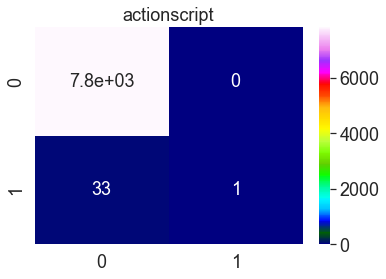

In [350]:
a = y1.columns[1]
sns.heatmap(conf_matrix_best_model[1], annot=True, cmap='gist_ncar')
plt.title(a, fontdict={"fontsize": 18})
plt.show()

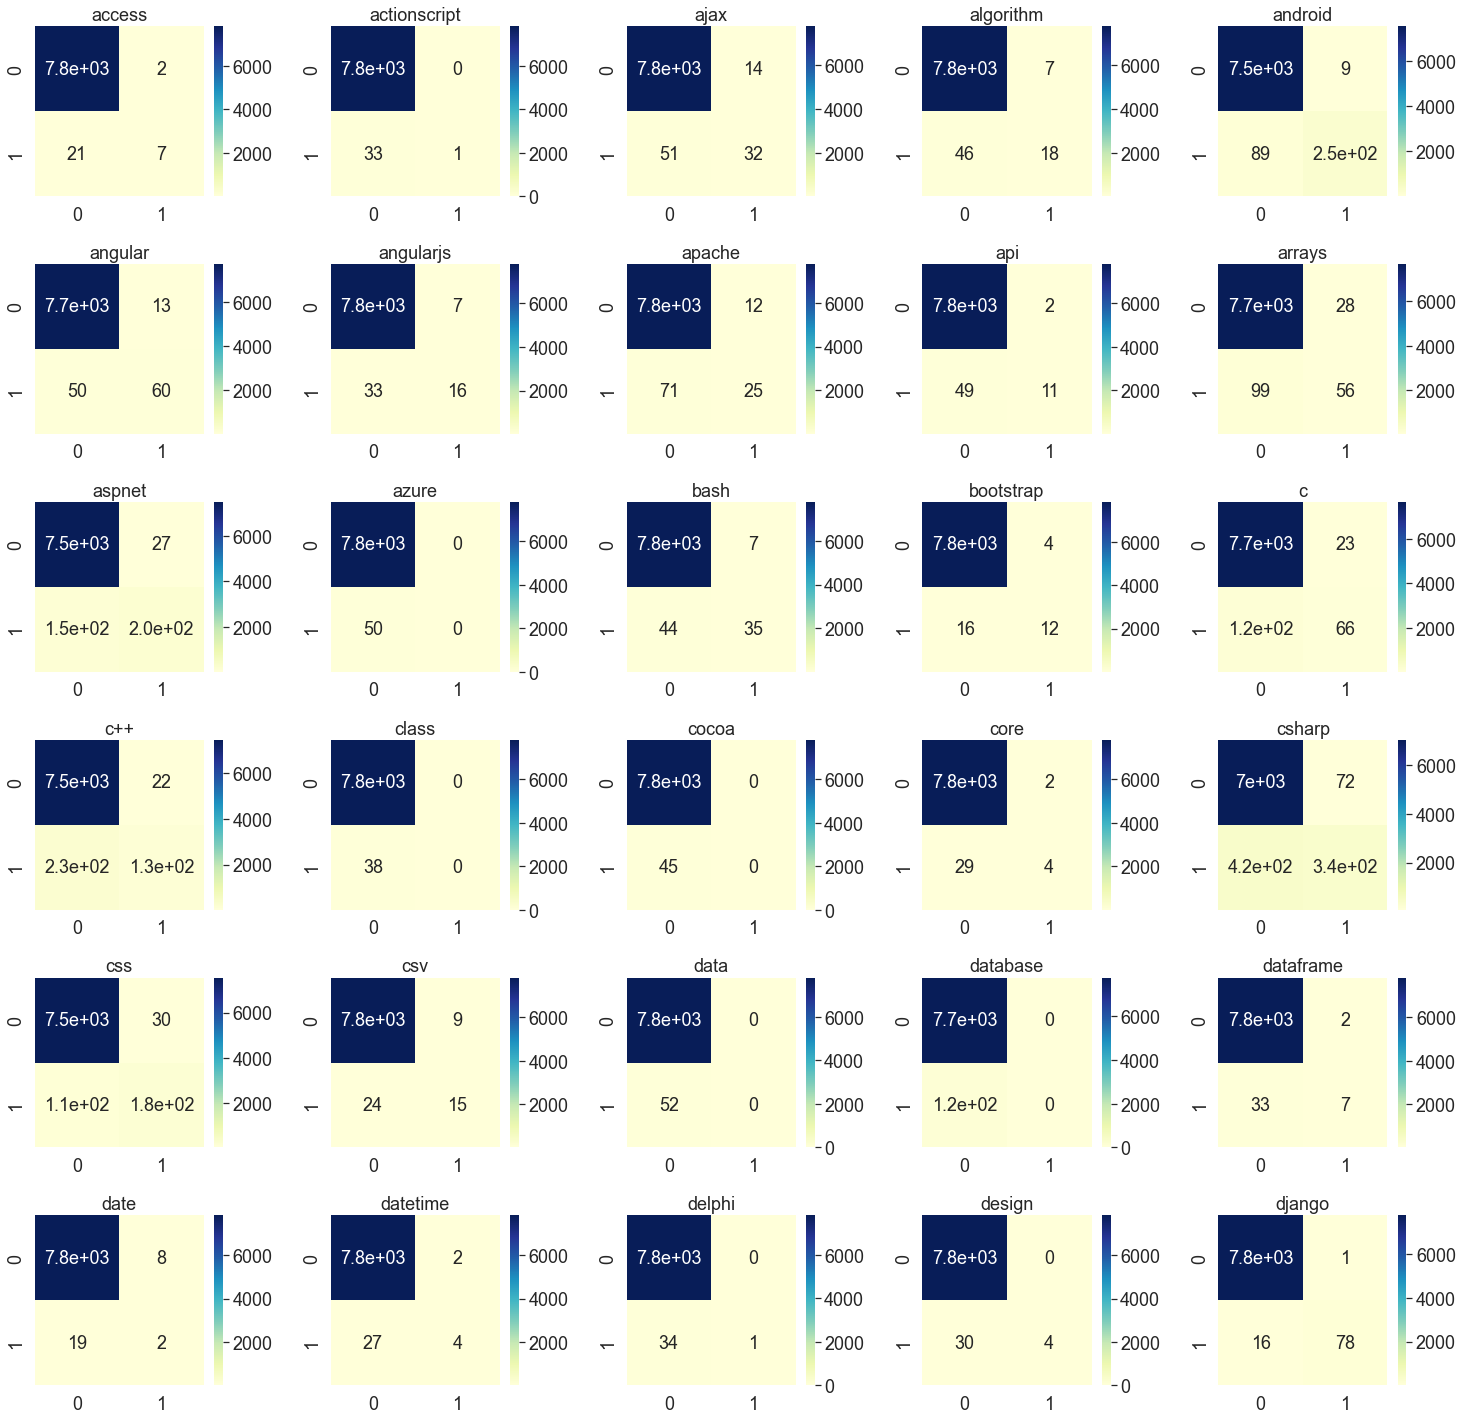

In [353]:
fig = plt.figure(figsize=(25, 25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(1,31):
    a = y1.columns[i]
    ax = fig.add_subplot(6, 5, i)
    i = i-1
    a = y1.columns[i]
    ax = sns.heatmap(conf_matrix_best_model[i], annot=True, cmap='YlGnBu')
    ax = plt.title(a, fontdict={"fontsize": 18})

In [242]:
compare_tags_le_best_model = compar.head(30)
dfi.export(compare_tags_le_best_model, 'compare_tags_le_best_model.png')

In [245]:
vide = compar[compar['Predictions_le_ best_model']==()]
a = vide.shape[0]
b = compar.shape[0]
t_le_best_model = (a/b)*100
print('Le taux de réponse nulle du Meilleur modèle est de :', t_le_best_model,'%')

Le taux de réponse nulle du Meilleur modèle est de : 33.75302047564543 %


In [246]:
count_vide = vide['Test'].value_counts(dropna=False)
count_vide

(java,)                                          118
(c++,)                                            83
(csharp,)                                         79
(javascript,)                                     62
(python,)                                         56
(php,)                                            50
(r,)                                              41
(csharp, dotnet)                                  37
(android,)                                        36
(c,)                                              32
(ios,)                                            32
(windows,)                                        30
(azure,)                                          27
(apache,)                                         23
(google,)                                         23
(dotnet,)                                         21
(server, sql)                                     21
(on, rails, ruby)                                 21
(nodedotjs,)                                  

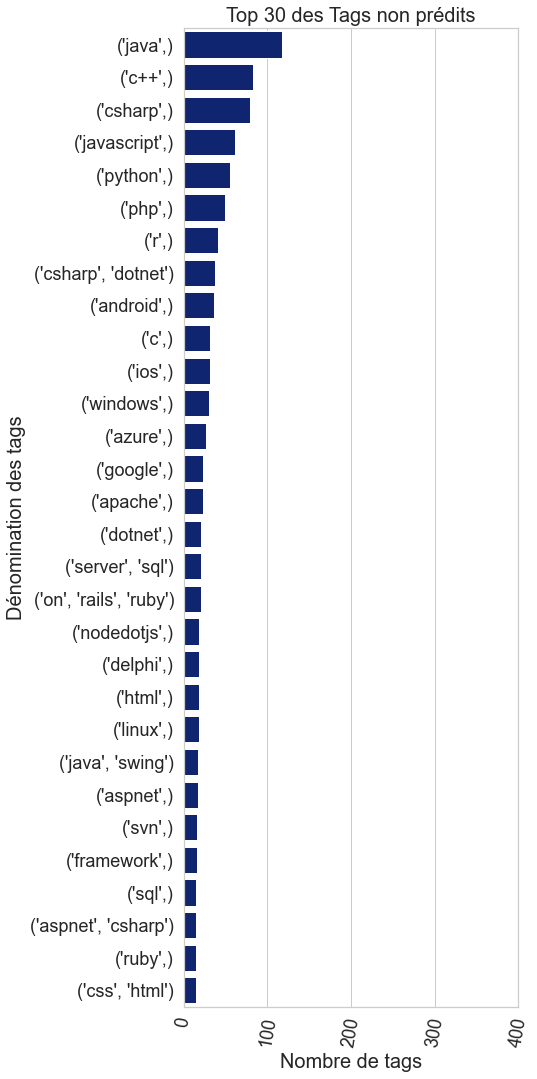

In [247]:
sns.set_theme(style="whitegrid")
sns.set_color_codes("dark")
plt.figure(figsize=(6, 18))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
cvd = count_vide.sort_values(ascending=False).head(30)
sns.barplot(x=cvd.values, y=cvd.index, color='b')
plt.xticks(rotation=80)
plt.xlabel("Nombre de tags")
plt.ylabel("Dénomination des tags")
plt.title("Top 30 des Tags non prédits")
plt.xlim([0, 400])
plt.show()

In [250]:
pred = compar[compar['Predictions_le_ best_model']!=()]
count_compar_pred = pred['Predictions_le_ best_model'].value_counts(dropna=False)
count_compar_pred

(python,)                                     373
(java,)                                       297
(javascript,)                                 260
(csharp,)                                     259
(php,)                                        230
(android,)                                    197
(sql,)                                        159
(c++,)                                        122
(aspnet,)                                     113
(css, html)                                   104
(jquery,)                                     100
(c,)                                           79
(mysql,)                                       75
(r,)                                           73
(iphone,)                                      72
(server, sql)                                  69
(html,)                                        67
(javascript, jquery)                           61
(regex,)                                       53
(excel, vba)                                   51


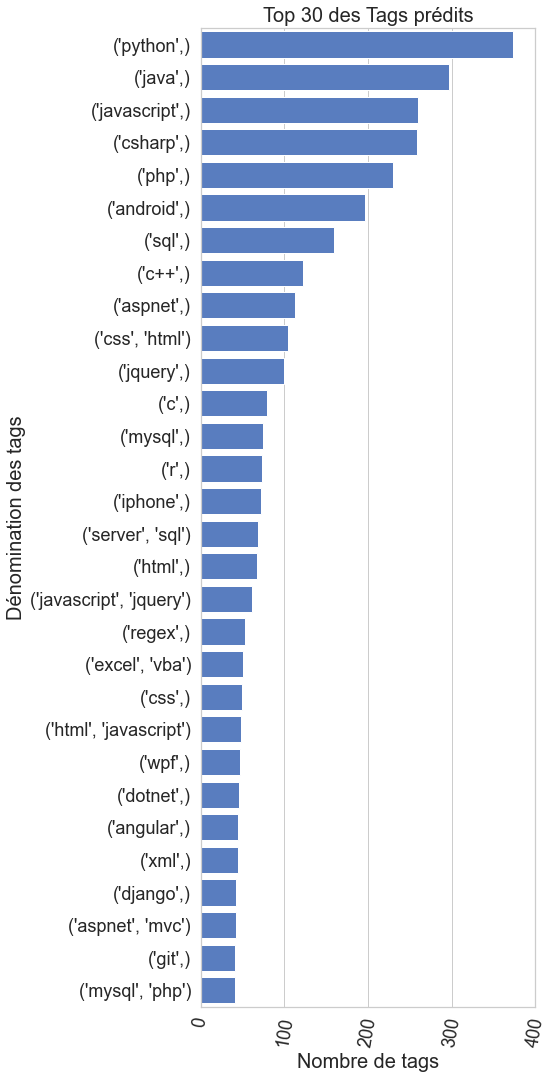

In [251]:
sns.set_theme(style="whitegrid")
sns.set_color_codes("muted")
plt.figure(figsize=(6, 18))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
cpred = count_compar_pred.sort_values(ascending=False).head(30)
sns.barplot(x=cpred.values, y=cpred.index, color='b')
plt.xticks(rotation=80)
plt.xlabel("Nombre de tags")
plt.ylabel("Dénomination des tags")
plt.title("Top 30 des Tags prédits")
plt.xlim([0, 400])
plt.show()

In [252]:
count_compar = compar['Test'].value_counts(dropna=False)
count_compar

(java,)                                           306
(python,)                                         256
(javascript,)                                     193
(android,)                                        190
(csharp,)                                         182
(c++,)                                            181
(php,)                                            168
(css, html)                                       109
(r,)                                              108
(server, sql)                                     104
(csharp, dotnet)                                   87
(c,)                                               87
(javascript, jquery)                               75
(jquery,)                                          69
(excel, vba)                                       62
(mysql, php)                                       58
(on, rails, ruby)                                  57
(html, javascript)                                 56
(aspnet, mvc)               

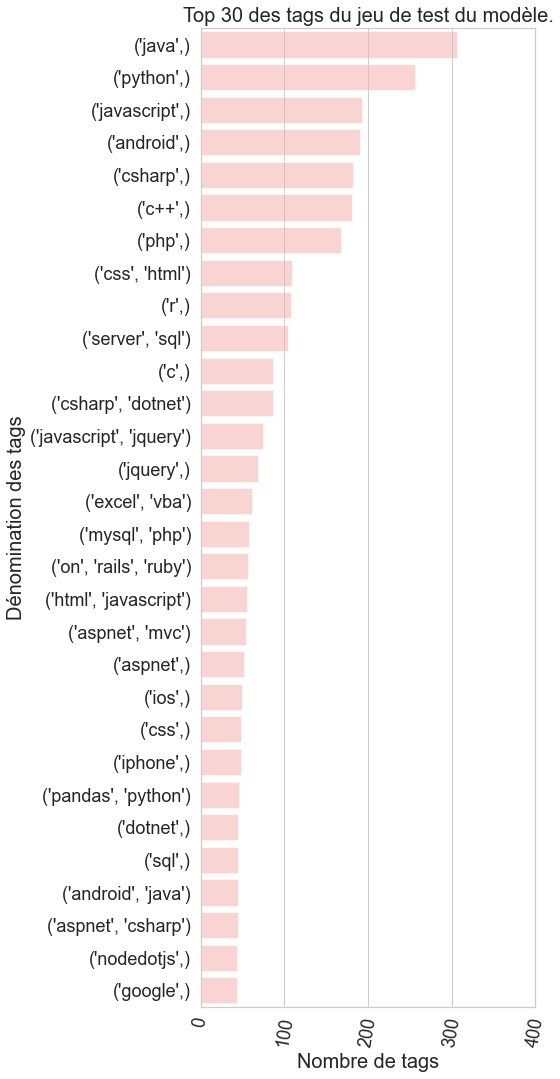

In [253]:
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
plt.figure(figsize=(6, 18))
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
ccp = count_compar.sort_values(ascending=False).head(30)
sns.barplot(x=ccp.values, y=ccp.index, color="r", alpha  = 0.5)
plt.xticks(rotation=80)
plt.xlabel("Nombre de tags")
plt.ylabel("Dénomination des tags")
plt.title("Top 30 des tags du jeu de test du modèle.")
plt.xlim([0, 400])
plt.show()

In [254]:
tags_test = count_compar.to_frame()

tags_test

,Test
"(java,)",306
"(python,)",256
"(javascript,)",193
"(android,)",190
"(csharp,)",182
"(c++,)",181
"(php,)",168
"(css, html)",109
"(r,)",108
"(server, sql)",104


In [255]:
tags_prédits = count_compar_pred.to_frame()
tags_prédits.columns = ['Prédits']
tags_prédits

,Prédits
"(python,)",373
"(java,)",297
"(javascript,)",260
"(csharp,)",259
"(php,)",230
"(android,)",197
"(sql,)",159
"(c++,)",122
"(aspnet,)",113
"(css, html)",104


In [256]:
tags_non_prédits = count_vide.to_frame()
tags_non_prédits.columns = ['Non_Prédits']
tags_non_prédits

,Non_Prédits
"(java,)",118
"(c++,)",83
"(csharp,)",79
"(javascript,)",62
"(python,)",56
"(php,)",50
"(r,)",41
"(csharp, dotnet)",37
"(android,)",36
"(c,)",32


In [257]:
result = pd.concat([tags_test, tags_prédits, tags_non_prédits], axis=1, join="inner")

In [258]:
result

,Test,Prédits,Non_Prédits
"(java,)",306,297,118
"(python,)",256,373,56
"(javascript,)",193,260,62
"(android,)",190,197,36
"(csharp,)",182,259,79
"(c++,)",181,122,83
"(php,)",168,230,50
"(css, html)",109,104,15
"(r,)",108,73,41
"(server, sql)",104,69,21


In [259]:
result1 = result.head(30)

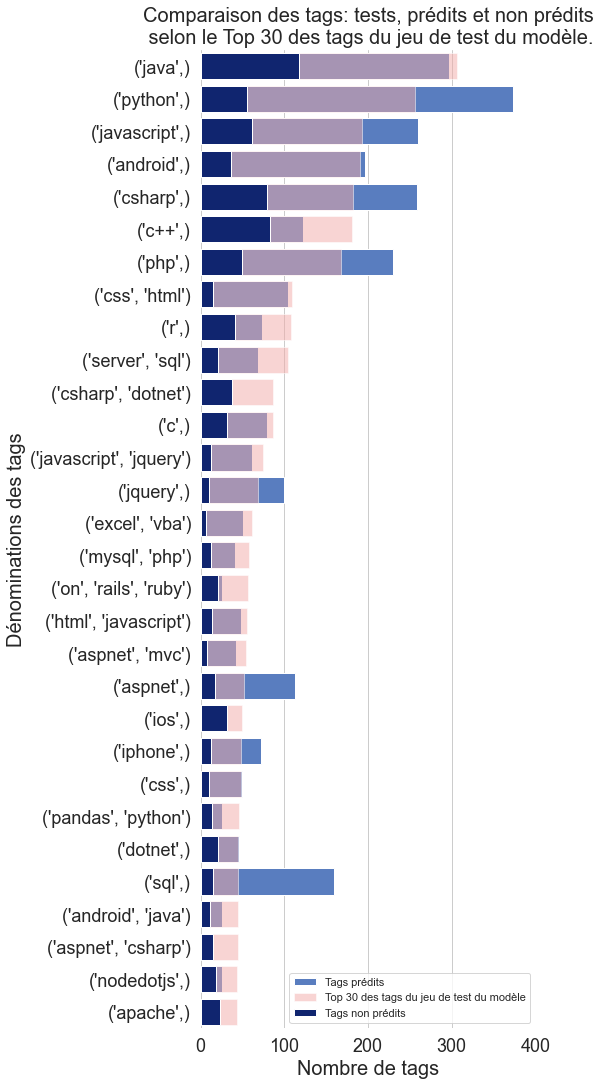

In [269]:
sns.set_theme(style="whitegrid")

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 18))

# Plot Top 30 des Tags prédits
sns.set_color_codes("muted")
sns.barplot(x=result1['Prédits'].values, y=result1.index,
            label="Tags prédits", color="b")

# Plot Top 30 des tags du jeu d'entraînement du modèle
sns.set_color_codes("pastel")
sns.barplot(x=result1['Test'].values, y=result1.index,
            label="Top 30 des tags du jeu de test du modèle", color="r", alpha  = 0.5)

# Plot Top 30 des Tags non prédits
sns.set_color_codes("dark")
sns.barplot(x=result1['Non_Prédits'].values, y=result1.index,
            label="Tags non prédits", color="b")

# Add a legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 400), ylabel="Dénominations des tags",
       xlabel="Nombre de tags", title="Comparaison des tags: tests, prédits et non prédits\n selon le Top 30 des tags du jeu de test du modèle.")
sns.despine(left=True, bottom=True)

#### Export du meilleur modèle optimisé et des préprocessings :

In [261]:
joblib.dump(le_best_model,'le_best_model.pkl')  

['le_best_model.pkl']

In [262]:
joblib.dump(vectorizer,'le_tfidf_vectorizer.pkl')

['le_tfidf_vectorizer.pkl']

In [263]:
joblib.dump(mlb,'le_multilabel_binarizer.pkl')

['le_multilabel_binarizer.pkl']

In [264]:
end_dr1 = time.process_time()
time_dr1 = end_dr1 - start_dr1
print('Run Time :', time_dr1)

Run Time : 9687.609375
